# Distance Correlation Plot

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


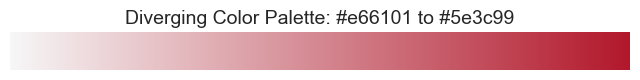

In [18]:
import pandas as pd
from local_pkgs.proj_pkg import eda_plots as eda
import yaml
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

with open("thermoelectric_properties.yaml", "r", encoding="utf-8") as file:
    properties = yaml.safe_load(file)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 1))
fig.subplots_adjust(bottom=0.5)
colors = ['#f7f7f7','#b2182b']

# Generate a colormap
gradient = [colors]
cmap = LinearSegmentedColormap.from_list("CustomDiverging", colors)

# Show the gradient
gradient_image = ax.imshow([list(range(256))], aspect='auto', cmap=cmap)
ax.set_axis_off()

# Add a title
plt.title("Diverging Color Palette: #e66101 to #5e3c99", fontsize=14)
plt.show()

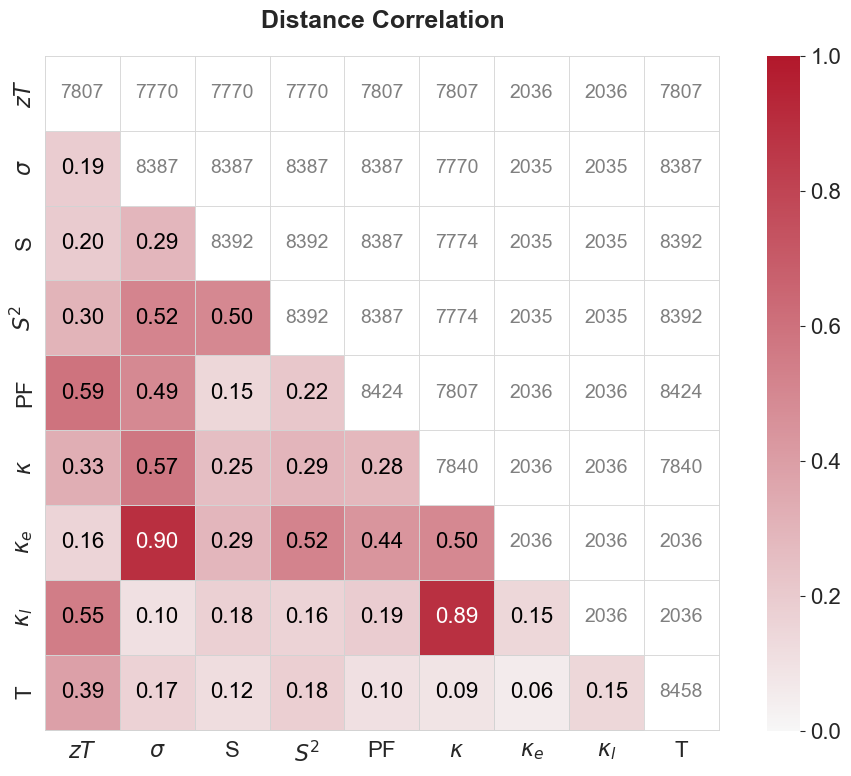

In [19]:
df = pd.read_excel("data/sysTEm_dataset.xlsx")

prop_short = []
df_copy = df.copy()

for prop, vals in properties.items():
    df_copy = df_copy.rename(columns={vals['column_name']: vals['short_name']})
    prop_short.append(vals['short_name'])

# Add temperature column
df_copy = df_copy.rename(columns={'Temperature (K)': 'T'})
prop_short.append('T')

# Add S^2 remove S
df_copy['$S^2$'] = df_copy['S']**2
prop_short.append('$S^2$')


# reorder the columns
prop_short = ['$zT$', '$\sigma$', 'S', '$S^2$', 'PF', '$\kappa$', '$\kappa_e$', '$\kappa_l$', 'T']

# output = 'figures/dcorr_heatmap.pdf'

output = None

title = 'Distance Correlation'

eda.plot_distance_correlation_full_heatmap(df_copy, prop_short, title, colormap=cmap, savefig=output)


# Barplots Results

## MT CrabNet Vs. Baselines

In [1]:
import local_pkgs.proj_pkg.ml_plots as mplots
import os
import pandas as pd
import yaml
import local_pkgs.proj_pkg.preprocessing as preprocess
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np


with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

seeds = [1, 42, 88, 123, 1201]

/Users/drago/Anaconda/anaconda3/envs/mt-crabnet_localenv/lib/python3.10/site-packages/matminer/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
## RF
consolidated_df = pd.DataFrame()  # Used to store the results for all properties

for prop, v in config.items():
    r2_ls = []
    mae_ls = []
    rmse_ls = []
    for random_seed in seeds:
        file = f'results/final/Random Forest/Seed{random_seed}_OuterFold5_NoScaler_Direct Composition_{prop}/actual_vs_predicted.csv'

        df_pred = pd.read_csv(file)

        scores_dict = mplots.consolidate_scores(
            df_pred['Actual'],
            df_pred['Predicted'],
            fold_column=df_pred['K_Fold']
        )


        # Add extra columns to the results
        r2_ls.extend(scores_dict['r2_scores'])
        mae_ls.extend(scores_dict['mae_scores'])
        rmse_ls.extend(scores_dict['rmse_scores'])

    # Calculate mean and standard error for the property
    mean_r2 = np.mean(r2_ls)
    std_err_r2 = np.std(r2_ls) / np.sqrt(len(r2_ls))
    mean_mae = np.mean(mae_ls)
    std_err_mae = np.std(mae_ls) / np.sqrt(len(mae_ls))
    mean_rmse = np.mean(rmse_ls)
    std_err_rmse = np.std(rmse_ls) / np.sqrt(len(rmse_ls))

    results_dict = {
        "r2_mean" : mean_r2,
        "r2_se" : std_err_r2,
        "mae_mean" : mean_mae,
        "mae_se" : std_err_mae,
        "rmse_mean" : mean_rmse,
        "rmse_se" : std_err_rmse,
        'model_name' : 'Random Forest',
        'property' : prop,
        'random_seed' : ", ".join([str(seed) for seed in seeds])
    }
    results_df = pd.DataFrame([results_dict])  # Create a single-row DataFrame
    consolidated_df = pd.concat([consolidated_df, results_df], ignore_index=True)


# Define the desired column order
column_order = ['model_name', 'property', 'random_seed'] + [col for col in consolidated_df.columns if col not in ['model_name', 'property', 'random_seed']]

# Reorder the columns in the DataFrame
consolidated_df = consolidated_df.reindex(columns=column_order)

# Display or save consolidated_df as needed
print(consolidated_df)

# Save the results
# consolidated_df.to_csv('results/final/RF_results.csv', index=False)

/Users/drago/Anaconda/anaconda3/envs/mt-crabnet_localenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/drago/Anaconda/anaconda3/envs/mt-crabnet_localenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


      model_name property           random_seed   r2_mean     r2_se  \
0  Random Forest        k  1, 42, 88, 123, 1201  0.748862  0.019919   
1  Random Forest       ke  1, 42, 88, 123, 1201  0.494670  0.021695   
2  Random Forest       kl  1, 42, 88, 123, 1201  0.714241  0.016673   
3  Random Forest    sigma  1, 42, 88, 123, 1201  0.670934  0.013087   
4  Random Forest        S  1, 42, 88, 123, 1201  0.797398  0.008612   
5  Random Forest       PF  1, 42, 88, 123, 1201  0.816981  0.008089   
6  Random Forest       zT  1, 42, 88, 123, 1201  0.790721  0.009083   

     mae_mean    mae_se   rmse_mean    rmse_se  
0    0.498177  0.010588    1.064897   0.045110  
1    0.288046  0.010764    0.476496   0.018794  
2    0.428216  0.013064    0.922539   0.030852  
3  285.353220  5.359162  551.204176  13.875937  
4   53.653835  1.420990   92.173937   2.059472  
5    2.780526  0.045376    4.673772   0.099042  
6    0.123538  0.002479    0.198706   0.005237  


In [ ]:
## DopNet
consolidated_df = pd.DataFrame()  # Used to store the results for all properties

ratio = 10

for prop, v in config.items():

    r2_ls = []
    mae_ls = []
    rmse_ls = []
    for random_seed in seeds:
        file = f'results/final/DopNet/{prop}_preds_CompKFold_dopnet_ratio{ratio}_{random_seed}.csv'

        df_pred = pd.read_csv(file)

        scores_dict = mplots.consolidate_scores(
            df_pred['target'],
            df_pred['prediction'],
            fold_column=df_pred['K_fold']
        )

        # Add extra columns to the results
        r2_ls.extend(scores_dict['r2_scores'])
        mae_ls.extend(scores_dict['mae_scores'])
        rmse_ls.extend(scores_dict['rmse_scores'])

    # Calculate mean and standard error for the property
    mean_r2 = np.mean(r2_ls)
    std_err_r2 = np.std(r2_ls) / np.sqrt(len(r2_ls))
    mean_mae = np.mean(mae_ls)
    std_err_mae = np.std(mae_ls) / np.sqrt(len(mae_ls))
    mean_rmse = np.mean(rmse_ls)
    std_err_rmse = np.std(rmse_ls) / np.sqrt(len(rmse_ls))

    results_dict = {
        "r2_mean" : mean_r2,
        "r2_se" : std_err_r2,
        "mae_mean" : mean_mae,
        "mae_se" : std_err_mae,
        "rmse_mean" : mean_rmse,
        "rmse_se" : std_err_rmse,
        'model_name' : 'DopNet',
        'property' : prop,
        'random_seed' : ", ".join([str(seed) for seed in seeds])
    }
    results_df = pd.DataFrame([results_dict])  # Create a single-row DataFrame
    consolidated_df = pd.concat([consolidated_df, results_df], ignore_index=True)



    

# Define the desired column order
column_order = ['model_name', 'property', 'random_seed'] + [col for col in consolidated_df.columns if col not in ['model_name', 'property', 'random_seed']]

# Reorder the columns in the DataFrame
consolidated_df = consolidated_df.reindex(columns=column_order)

# Display or save consolidated_df as needed
print(consolidated_df)

# Save the results
consolidated_df.to_csv(f'results/final/DopNet_results_ratio{ratio}.csv', index=False)

  model_name property           random_seed   r2_mean     r2_se    mae_mean  \
0     DopNet        k  1, 42, 88, 123, 1201  0.723041  0.008405    0.523132   
1     DopNet       ke  1, 42, 88, 123, 1201  0.467337  0.019849    0.281564   
2     DopNet       kl  1, 42, 88, 123, 1201  0.708477  0.012924    0.430799   
3     DopNet    sigma  1, 42, 88, 123, 1201  0.555360  0.048027  286.603982   
4     DopNet        S  1, 42, 88, 123, 1201  0.766240  0.013213   52.290150   
5     DopNet       PF  1, 42, 88, 123, 1201  0.802311  0.008698    2.705456   
6     DopNet       zT  1, 42, 88, 123, 1201  0.785544  0.005303    0.129128   

      mae_se   rmse_mean    rmse_se  
0   0.010545    1.143795   0.039969  
1   0.010009    0.491419   0.019723  
2   0.012956    0.938410   0.027621  
3  16.740261  625.773850  30.311619  
4   1.751234   98.755432   2.827067  
5   0.044018    4.863965   0.115217  
6   0.002168    0.201464   0.003085  


In [ ]:
## MT CrabNet
consolidated_df = pd.DataFrame()  # Used to store the results for all properties


extra_features_strategies = ['concat_at_input', 'tile_at_input', 'concat_at_output']


for prop, v in config.items():
    for strategy in extra_features_strategies:
        r2_ls = []
        mae_ls = []
        rmse_ls = []
        for random_seed in seeds:
            file = f'results/final/MT-CrabNet/MultiTask_RobustL2_matscibert_{strategy}_onehotappendconcat_at_attn_5splits_seed{random_seed}.csv'

            df_pred = pd.read_csv(file)

            # Filter the DataFrame to only include the property of interest
            df_pred = df_pred[df_pred['Property'] == v['column_name']]


            scores_dict = mplots.consolidate_scores(
                df_pred['Actual'],
                df_pred['Predicted'],
                fold_column=df_pred['K_fold']
            )

            # Add extra columns to the results
            r2_ls.extend(scores_dict['r2_scores'])
            mae_ls.extend(scores_dict['mae_scores'])
            rmse_ls.extend(scores_dict['rmse_scores'])

        # Calculate mean and standard error for the property
        mean_r2 = np.mean(r2_ls)
        std_err_r2 = np.std(r2_ls) / np.sqrt(len(r2_ls))
        mean_mae = np.mean(mae_ls)
        std_err_mae = np.std(mae_ls) / np.sqrt(len(mae_ls))
        mean_rmse = np.mean(rmse_ls)
        std_err_rmse = np.std(rmse_ls) / np.sqrt(len(rmse_ls))

        results_dict = {
            "r2_mean" : mean_r2,
            "r2_se" : std_err_r2,
            "mae_mean" : mean_mae,
            "mae_se" : std_err_mae,
            "rmse_mean" : mean_rmse,
            "rmse_se" : std_err_rmse,
            'model_name' : f'MT CrabNet {strategy}',
            'property' : prop,
            'random_seed' : ", ".join([str(seed) for seed in seeds])
        }
        results_df = pd.DataFrame([results_dict])  # Create a single-row DataFrame
        consolidated_df = pd.concat([consolidated_df, results_df], ignore_index=True)
    

# Define the desired column order
column_order = ['model_name', 'property', 'random_seed'] + [col for col in consolidated_df.columns if col not in ['model_name', 'property', 'random_seed']]

# Reorder the columns in the DataFrame
consolidated_df = consolidated_df.reindex(columns=column_order)

# Display or save consolidated_df as needed
print(consolidated_df)

# Save the results
consolidated_df.to_csv('results/final/MT_main.csv', index=False)

                     model_name property           random_seed   r2_mean  \
0    MT CrabNet concat_at_input        k  1, 42, 88, 123, 1201  0.797471   
1      MT CrabNet tile_at_input        k  1, 42, 88, 123, 1201  0.789395   
2   MT CrabNet concat_at_output        k  1, 42, 88, 123, 1201  0.796552   
3    MT CrabNet concat_at_input       ke  1, 42, 88, 123, 1201  0.650547   
4      MT CrabNet tile_at_input       ke  1, 42, 88, 123, 1201  0.643059   
5   MT CrabNet concat_at_output       ke  1, 42, 88, 123, 1201  0.647814   
6    MT CrabNet concat_at_input       kl  1, 42, 88, 123, 1201  0.756684   
7      MT CrabNet tile_at_input       kl  1, 42, 88, 123, 1201  0.742109   
8   MT CrabNet concat_at_output       kl  1, 42, 88, 123, 1201  0.747405   
9    MT CrabNet concat_at_input    sigma  1, 42, 88, 123, 1201  0.731593   
10     MT CrabNet tile_at_input    sigma  1, 42, 88, 123, 1201  0.722171   
11  MT CrabNet concat_at_output    sigma  1, 42, 88, 123, 1201  0.733033   
12   MT Crab

In [7]:
file_1 = 'results/final/RF_results.csv'
file_2 = 'results/final/DopNet_results_ratio10.csv'
file_3 = 'results/final/MT_main.csv'

df_1 = pd.read_csv(file_1)
df_2 = pd.read_csv(file_2)
df_3 = pd.read_csv(file_3)

df = pd.concat([df_1, df_2, df_3], ignore_index=True)

df.to_csv('results/final/plot_results/consolidated_main.csv', index=False)

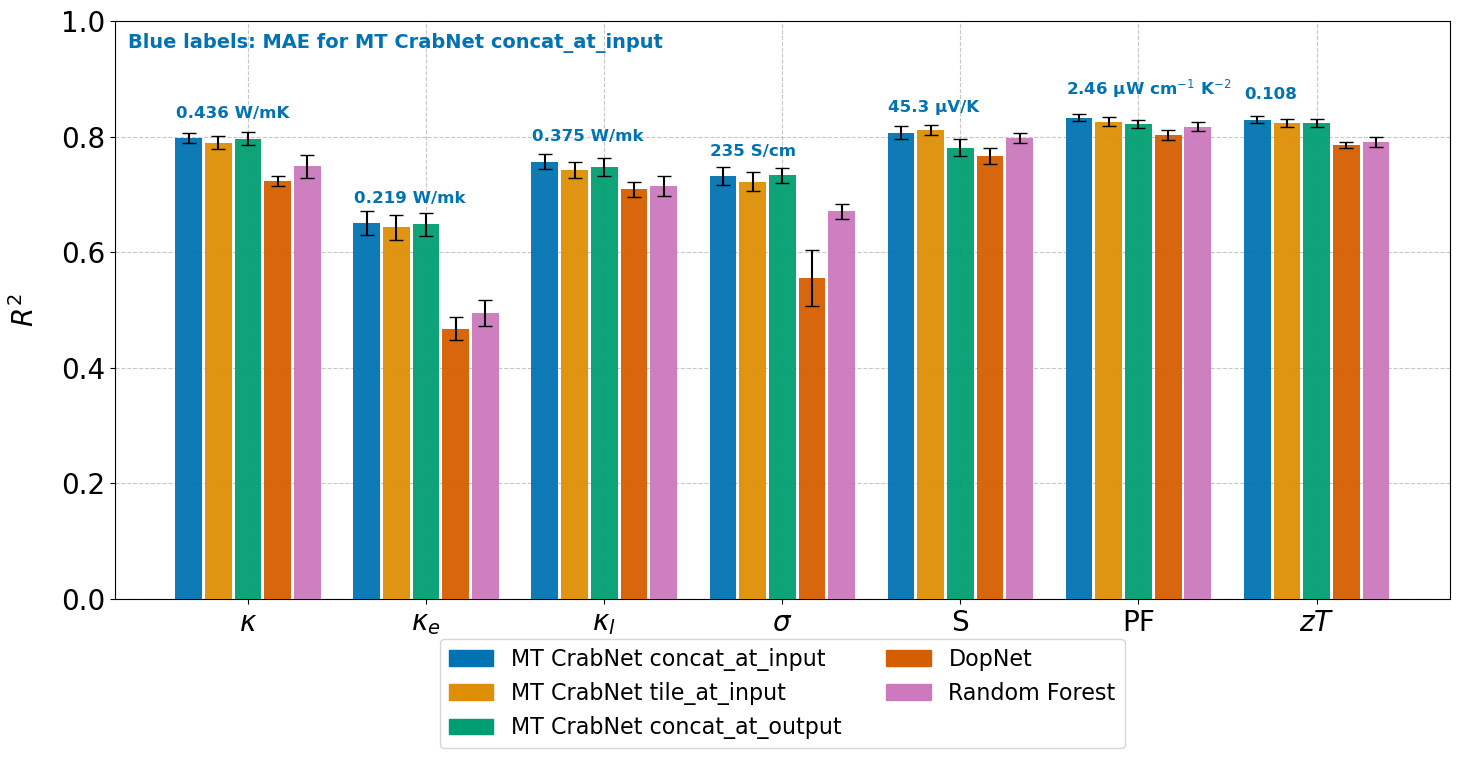

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import local_pkgs.proj_pkg.graph_settings

# Load YAML configuration
with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load the dataset
file_path = f'results/final/plot_results/consolidated_main.csv'
data = pd.read_csv(file_path)

# Define model order and corresponding colors
model_order = [
    "MT CrabNet concat_at_input", "MT CrabNet tile_at_input", 
    "MT CrabNet concat_at_output", "DopNet", "Random Forest"
]

property_order = list(config.keys())

palette = sns.color_palette("colorblind", len(model_order))
model_colors = dict(zip(model_order, palette))

# Filter data by model order
data = data[data['model_name'].isin(model_order)]
data['model_name'] = pd.Categorical(data['model_name'], categories=model_order, ordered=True)

# Sort data by property and model
data = data.sort_values(by=['property', 'model_name'])

# Create the plot
plt.figure(figsize=(15, 8))
plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0)

bar_width = 0.9  # keep in one place

# Loop through properties to add bar plots
current_position = 0
positions = []
property_labels = {}

ax = plt.gca()

for prop in property_order:
    prop_data = data[data['property'] == prop]

    bar_positions = range(current_position, current_position + len(prop_data))
    plt.bar(
        bar_positions,
        prop_data['r2_mean'],
        color=[model_colors[model] for model in prop_data['model_name']],
        yerr=prop_data['r2_se'],
        capsize=5,
        width=bar_width,
        alpha=0.95,
        zorder=3
    )

    # --- Annotate MAE for concat_at_input (left-aligned at left edge of the blue bar) ---
    concat_row = prop_data[prop_data['model_name'] == "MT CrabNet concat_at_input"]
    if not concat_row.empty:
        mae_value = concat_row['mae_mean'].values[0]
        if config[prop]['units'] is None:
            mae_text = f"{mae_value:.3g}"
        else:
            mae_text = f"{mae_value:.3g} {config[prop]['units']}"
        bar_index = list(prop_data['model_name']).index("MT CrabNet concat_at_input")
        xpos_center = current_position + bar_index
        xpos_left = xpos_center - bar_width/2 + 0.02  # nudge inside the left edge
        ypos = concat_row['r2_mean'].values[0]

        plt.text(
            xpos_left, ypos + 0.03,           # a little above the bar
            mae_text,
            ha='left', va='bottom',           # left-align the text
            fontsize=12,
            color=model_colors["MT CrabNet concat_at_input"],
            fontweight='bold'
        )

    middle_position = current_position + len(prop_data) // 2
    property_labels[middle_position] = config[prop]['short_name']

    positions.extend(bar_positions)
    current_position += len(prop_data) + 1

# X/Y ticks and labels
plt.xticks(list(property_labels.keys()), list(property_labels.values()), ha='center', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r"$R^2$", fontsize=20, labelpad=15)

# --- Give the chart more space above the bars ---
max_val = (data['r2_mean'] + data['r2_se']).max()
ax.set_ylim(0, min(1.0, max_val + 0.20))  # add headroom; cap at 1.0
plt.margins(y=0.12)                       

# Legend

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in palette]
plt.legend(
    handles, model_order, loc="upper center",
    bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=16
)

# --- Caption to clarify the blue numbers are MAE ---
ax.text(
    0.01, 0.98, "Blue labels: MAE for MT CrabNet concat_at_input",
    transform=ax.transAxes, ha='left', va='top',
    fontsize=14, fontweight='bold',
    color=model_colors["MT CrabNet concat_at_input"]
)

plt.tight_layout()
# plt.savefig("figures/mt_crabnet_versus_baselines.pdf", bbox_inches="tight")
plt.show()

## MT vs ST CrabNet

In [ ]:
import local_pkgs.proj_pkg.ml_plots as mplots
import os
import pandas as pd
import yaml
import local_pkgs.proj_pkg.preprocessing as preprocess
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np


with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

seeds = [1, 42, 88, 123, 1201]

In [ ]:
## ST
consolidated_df = pd.DataFrame()  # Used to store the results for all properties

extra_features_strategies = ['concat_at_input', 'tile_at_input', 'concat_at_output']

for prop, v in config.items():
    for strategy in extra_features_strategies:
        r2_ls = []
        mae_ls = []
        rmse_ls = []
        for random_seed in seeds:
            file = f'results/final/ST-CrabNet/SingleTask_StandardTransform_{prop}_RobustL2_DopedCrab_matscibert_{strategy}_5splits_Seed{random_seed}.csv'

            df_pred = pd.read_csv(file)

            scores_dict = mplots.consolidate_scores(
                df_pred['Actual'],
                df_pred['Predicted'],
                fold_column=df_pred['K_fold']
            )


            # Add extra columns to the results
            r2_ls.extend(scores_dict['r2_scores'])
            mae_ls.extend(scores_dict['mae_scores'])
            rmse_ls.extend(scores_dict['rmse_scores'])

        # Calculate mean and standard error for the property
        mean_r2 = np.mean(r2_ls)
        std_err_r2 = np.std(r2_ls) / np.sqrt(len(r2_ls))
        mean_mae = np.mean(mae_ls)
        std_err_mae = np.std(mae_ls) / np.sqrt(len(mae_ls))
        mean_rmse = np.mean(rmse_ls)
        std_err_rmse = np.std(rmse_ls) / np.sqrt(len(rmse_ls))

        results_dict = {
            "r2_mean" : mean_r2,
            "r2_se" : std_err_r2,
            "mae_mean" : mean_mae,
            "mae_se" : std_err_mae,
            "rmse_mean" : mean_rmse,
            "rmse_se" : std_err_rmse,
            'model_name' : f'ST CrabNet {strategy}',
            'property' : prop,
            'random_seed' : ", ".join([str(seed) for seed in seeds])
        }
        results_df = pd.DataFrame([results_dict])  # Create a single-row DataFrame
        consolidated_df = pd.concat([consolidated_df, results_df], ignore_index=True)

# Define the desired column order
column_order = ['model_name', 'property', 'random_seed'] + [col for col in consolidated_df.columns if col not in ['model_name', 'property', 'random_seed']]

# Reorder the columns in the DataFrame
consolidated_df = consolidated_df.reindex(columns=column_order)

# Display or save consolidated_df as needed
print(consolidated_df)

# Save the results
consolidated_df.to_csv('results/final/ST_results.csv', index=False)




                     model_name property           random_seed   r2_mean  \
0    ST CrabNet concat_at_input        k  1, 42, 88, 123, 1201  0.776483   
1      ST CrabNet tile_at_input        k  1, 42, 88, 123, 1201  0.783712   
2   ST CrabNet concat_at_output        k  1, 42, 88, 123, 1201  0.757238   
3    ST CrabNet concat_at_input       ke  1, 42, 88, 123, 1201  0.439109   
4      ST CrabNet tile_at_input       ke  1, 42, 88, 123, 1201  0.417919   
5   ST CrabNet concat_at_output       ke  1, 42, 88, 123, 1201  0.425136   
6    ST CrabNet concat_at_input       kl  1, 42, 88, 123, 1201  0.714807   
7      ST CrabNet tile_at_input       kl  1, 42, 88, 123, 1201  0.695842   
8   ST CrabNet concat_at_output       kl  1, 42, 88, 123, 1201  0.691367   
9    ST CrabNet concat_at_input    sigma  1, 42, 88, 123, 1201  0.709508   
10     ST CrabNet tile_at_input    sigma  1, 42, 88, 123, 1201  0.709316   
11  ST CrabNet concat_at_output    sigma  1, 42, 88, 123, 1201  0.681479   
12   ST Crab

In [12]:
file_1 = 'results/final/ST_results.csv'
file_2 = 'results/final/MT_main.csv'

df_1 = pd.read_csv(file_1)
df_2 = pd.read_csv(file_2)

df = pd.concat([df_1, df_2], ignore_index=True)

df.to_csv('results/final/plot_results/consolidated_STvsMT.csv', index=False)

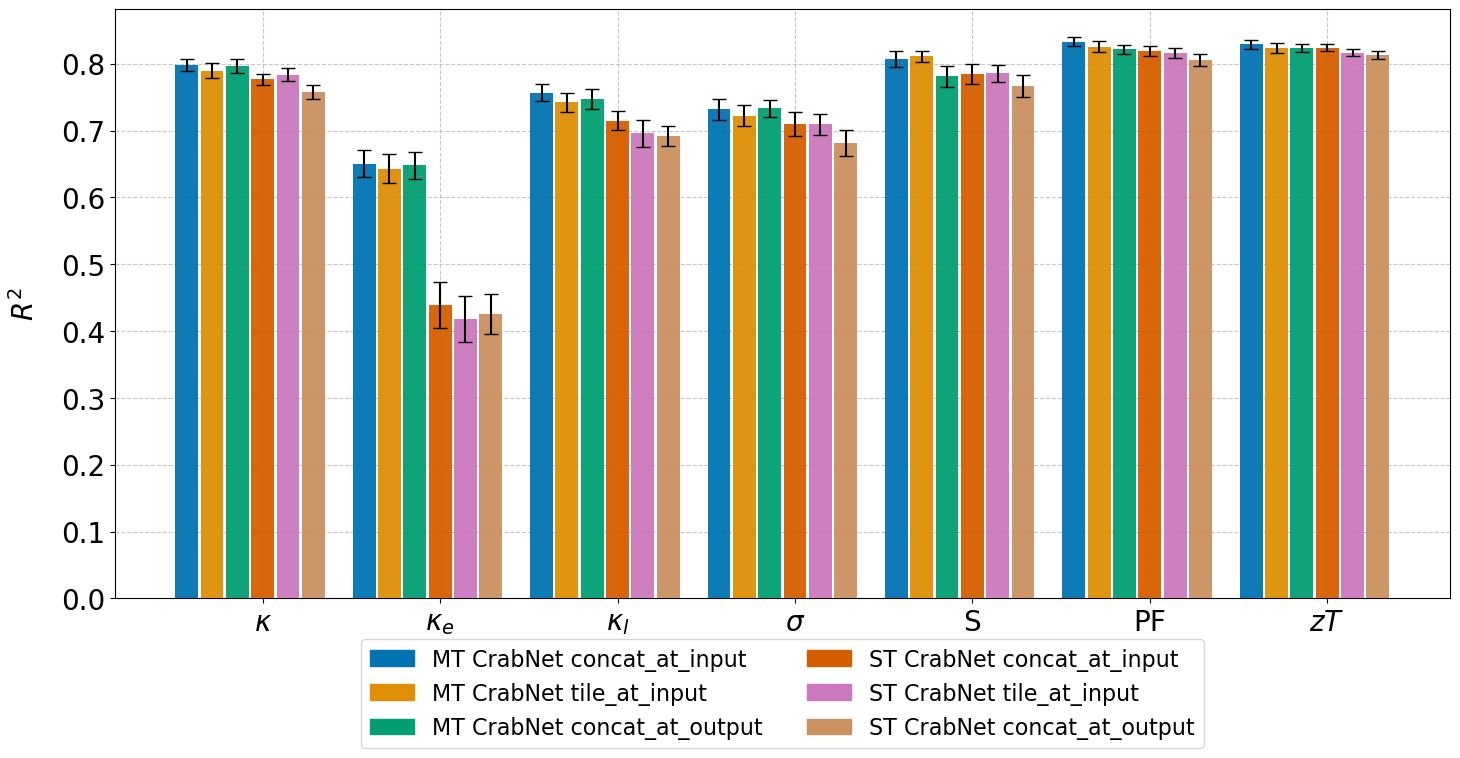

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import local_pkgs.proj_pkg.graph_settings

# Load YAML configuration
with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load the dataset
file_path = 'results/final/plot_results/consolidated_STvsMT.csv'
data = pd.read_csv(file_path)

# Define model order and corresponding colors
model_order = [
    "MT CrabNet concat_at_input", "MT CrabNet tile_at_input", 
    "MT CrabNet concat_at_output", "ST CrabNet concat_at_input", "ST CrabNet tile_at_input", 
    "ST CrabNet concat_at_output",
]

renamed_models = [
    "MT concat_at_input", "MT tile_at_input", 
    "MT concat_at_output", "ST concat_at_input", "ST tile_at_input", 
    "ST concat_at_output",
]


property_order = list(config.keys())

palette = sns.color_palette("colorblind", len(model_order))
model_colors = dict(zip(model_order, palette))

# Filter data by model order
data = data[data['model_name'].isin(model_order)]
data['model_name'] = pd.Categorical(data['model_name'], categories=model_order, ordered=True)

# Sort data by property and model
data = data.sort_values(by=['property', 'model_name'])

# Create the plot
plt.figure(figsize=(15, 8))
plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0)

# Loop through properties to add bar plots
current_position = 0
positions = []  # To track bar positions for each property
property_labels = {}  # Dictionary to track positions of property short names

for prop in property_order:
    # Get data for the specific property
    prop_data = data[data['property'] == prop]
    
    # Add bar plot for the property
    bar_positions = range(current_position, current_position + len(prop_data))
    plt.bar(
        bar_positions, 
        prop_data['r2_mean'], 
        color=[model_colors[model] for model in prop_data['model_name']], 
        yerr=prop_data['r2_se'],
        capsize=5,
        width=0.9,
        alpha=0.95,
        zorder=3  # Bars above gridlines
    )
    
    # Record the middle position for the property label
    middle_position = current_position + len(prop_data) // 2
    property_labels[middle_position] = config[prop]['short_name']
    
    # Update positions
    positions.extend(bar_positions)
    
    # Update current position, adding a gap for the next property
    current_position += len(prop_data) + 1  # Adding a gap between properties

# Set x-tick labels
plt.xticks(list(property_labels.keys()), list(property_labels.values()), ha='center', fontsize=20)

# y ticks
plt.yticks(fontsize=20)

# Rotate y-label
plt.ylabel(r"$R^2$", fontsize=20, labelpad=15)  # Rotate ylabel 90° clockwise


# Add legend outside the plot
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in palette]
plt.legend(
    handles, model_order, loc="upper center", 
    bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=16
)

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig("figures/mt_versus_st.pdf", bbox_inches="tight")
plt.show()

## L2 Vs L1 Norm

In [ ]:
import local_pkgs.proj_pkg.ml_plots as mplots
import os
import pandas as pd
import yaml
import local_pkgs.proj_pkg.preprocessing as preprocess
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np


with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
## MT CrabNet
consolidated_df = pd.DataFrame()  # Used to store the results for all properties


extra_features_strategies = ['concat_at_input', 'concat_at_output']

selector_vector_ls = ['0', 'concat_at_attn']

loss_ls = ['RobustL2', 'RobustL1']

random_seed = 42

for prop, v in config.items():
    for strategy in extra_features_strategies:
        for selector_vector in selector_vector_ls:
            for loss in loss_ls:
                r2_ls = []
                mae_ls = []
                rmse_ls = []

                file = f'results/final/MT-CrabNet/MultiTask_{loss}_matscibert_{strategy}_onehotappend{selector_vector}_5splits_seed{random_seed}.csv'

                df_pred = pd.read_csv(file)

                # Filter the DataFrame to only include the property of interest
                df_pred = df_pred[df_pred['Property'] == v['column_name']]


                scores_dict = mplots.consolidate_scores(
                    df_pred['Actual'],
                    df_pred['Predicted'],
                    fold_column=df_pred['K_fold']
                )

                # Add extra columns to the results
                r2_ls.extend(scores_dict['r2_scores'])
                mae_ls.extend(scores_dict['mae_scores'])
                rmse_ls.extend(scores_dict['rmse_scores'])

                # Calculate mean and standard error for the property
                mean_r2 = np.mean(r2_ls)
                std_err_r2 = np.std(r2_ls) / np.sqrt(len(r2_ls))
                mean_mae = np.mean(mae_ls)
                std_err_mae = np.std(mae_ls) / np.sqrt(len(mae_ls))
                mean_rmse = np.mean(rmse_ls)
                std_err_rmse = np.std(rmse_ls) / np.sqrt(len(rmse_ls))

                results_dict = {
                    "r2_mean" : mean_r2,
                    "r2_se" : std_err_r2,
                    "mae_mean" : mean_mae,
                    "mae_se" : std_err_mae,
                    "rmse_mean" : mean_rmse,
                    "rmse_se" : std_err_rmse,
                    'model_name' : f'MT CrabNet {loss} {strategy} {selector_vector}',
                    'property' : prop,
                    'random_seed' : random_seed
                }
                results_df = pd.DataFrame([results_dict])  # Create a single-row DataFrame
                consolidated_df = pd.concat([consolidated_df, results_df], ignore_index=True)
    

# Define the desired column order
column_order = ['model_name', 'property', 'random_seed'] + [col for col in consolidated_df.columns if col not in ['model_name', 'property', 'random_seed']]

# Reorder the columns in the DataFrame
consolidated_df = consolidated_df.reindex(columns=column_order)

# Display or save consolidated_df as needed
print(consolidated_df)

# Save the results
consolidated_df.to_csv('results/final/consolidated_L1vL2.csv', index=False)

                                           model_name property  random_seed  \
0               MT CrabNet RobustL2 concat_at_input 0        k           42   
1               MT CrabNet RobustL1 concat_at_input 0        k           42   
2   MT CrabNet RobustL2 concat_at_input concat_at_...        k           42   
3   MT CrabNet RobustL1 concat_at_input concat_at_...        k           42   
4              MT CrabNet RobustL2 concat_at_output 0        k           42   
5              MT CrabNet RobustL1 concat_at_output 0        k           42   
6   MT CrabNet RobustL2 concat_at_output concat_at...        k           42   
7   MT CrabNet RobustL1 concat_at_output concat_at...        k           42   
8               MT CrabNet RobustL2 concat_at_input 0       ke           42   
9               MT CrabNet RobustL1 concat_at_input 0       ke           42   
10  MT CrabNet RobustL2 concat_at_input concat_at_...       ke           42   
11  MT CrabNet RobustL1 concat_at_input concat_at_..

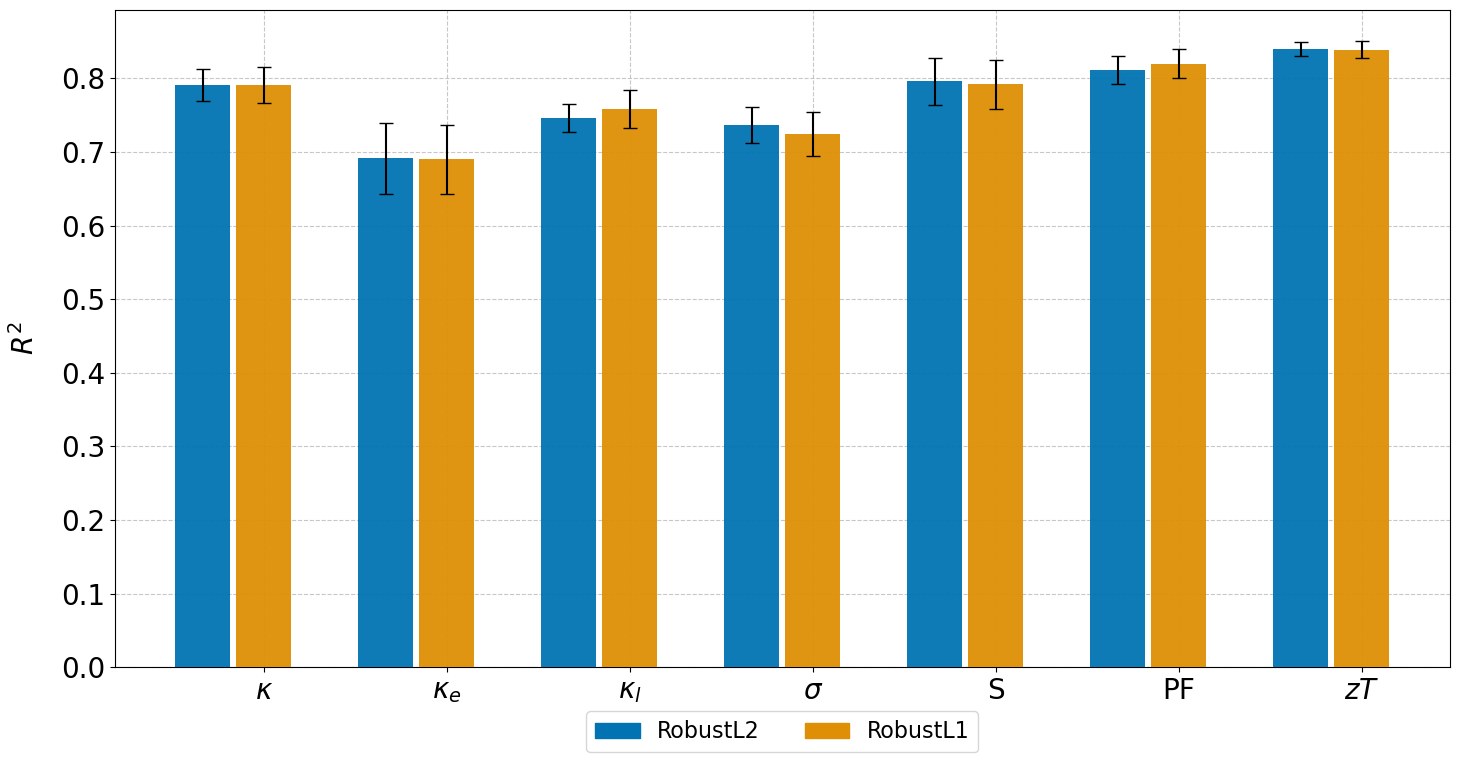

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import local_pkgs.proj_pkg.graph_settings

# Load YAML configuration
with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load the dataset
file_path = 'results/final/consolidated_L1vL2.csv'
data = pd.read_csv(file_path)

# Define model order and corresponding colors
model_order = [
    'MT CrabNet RobustL2 concat_at_input concat_at_attn', 'MT CrabNet RobustL1 concat_at_input concat_at_attn',
]

renamed_models = [
    'RobustL2', 'RobustL1',
]


property_order = list(config.keys())

palette = sns.color_palette("colorblind", len(model_order))
model_colors = dict(zip(model_order, palette))

# Filter data by model order
data = data[data['model_name'].isin(model_order)]
data['model_name'] = pd.Categorical(data['model_name'], categories=model_order, ordered=True)

# Sort data by property and model
data = data.sort_values(by=['property', 'model_name'])

# Create the plot
plt.figure(figsize=(15, 8))
plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0)

# Loop through properties to add bar plots
current_position = 0
positions = []  # To track bar positions for each property
property_labels = {}  # Dictionary to track positions of property short names

for prop in property_order:
    # Get data for the specific property
    prop_data = data[data['property'] == prop]
    
    # Add bar plot for the property
    bar_positions = range(current_position, current_position + len(prop_data))
    plt.bar(
        bar_positions, 
        prop_data['r2_mean'], 
        color=[model_colors[model] for model in prop_data['model_name']], 
        yerr=prop_data['r2_se'],
        capsize=5,
        width=0.9,
        alpha=0.95,
        zorder=3  # Bars above gridlines
    )
    
    # Record the middle position for the property label
    middle_position = current_position + len(prop_data) // 2
    property_labels[middle_position] = config[prop]['short_name']
    
    # Update positions
    positions.extend(bar_positions)
    
    # Update current position, adding a gap for the next property
    current_position += len(prop_data) + 1  # Adding a gap between properties

# Set x-tick labels
plt.xticks(list(property_labels.keys()), list(property_labels.values()), ha='center', fontsize=20)

# y ticks
plt.yticks(fontsize=20)

# Rotate y-label
plt.ylabel(r"$R^2$", fontsize=20, labelpad=15)  # Rotate ylabel 90° clockwise


# Add legend outside the plot
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in palette]
plt.legend(
    handles, renamed_models, loc="upper center", 
    bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=16
)

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig("figures/hyperparams_comparison_a.pdf", bbox_inches="tight")
plt.show()

## Elemental Embedding Differences

In [ ]:
import local_pkgs.proj_pkg.ml_plots as mplots
import os
import pandas as pd
import yaml
import local_pkgs.proj_pkg.preprocessing as preprocess
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np


with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
## MT CrabNet
consolidated_df = pd.DataFrame()  # Used to store the results for all properties


extra_features_strategies = ['concat_at_input', 'tile_at_input', 'concat_at_output']

embedding_ls = ['matscibert', 'mat2vec', 'oliynyk']

random_seed = 42

for prop, v in config.items():
    for strategy in extra_features_strategies:
        for embedding in embedding_ls:
            r2_ls = []
            mae_ls = []
            rmse_ls = []

            file = f'results/final/MT-CrabNet/MultiTask_RobustL2_{embedding}_{strategy}_onehotappendconcat_at_attn_5splits_seed{random_seed}.csv'

            df_pred = pd.read_csv(file)

            # Filter the DataFrame to only include the property of interest
            df_pred = df_pred[df_pred['Property'] == v['column_name']]


            scores_dict = mplots.consolidate_scores(
                df_pred['Actual'],
                df_pred['Predicted'],
                fold_column=df_pred['K_fold']
            )

            # Add extra columns to the results
            r2_ls.extend(scores_dict['r2_scores'])
            mae_ls.extend(scores_dict['mae_scores'])
            rmse_ls.extend(scores_dict['rmse_scores'])

            # Calculate mean and standard error for the property
            mean_r2 = np.mean(r2_ls)
            std_err_r2 = np.std(r2_ls) / np.sqrt(len(r2_ls))
            mean_mae = np.mean(mae_ls)
            std_err_mae = np.std(mae_ls) / np.sqrt(len(mae_ls))
            mean_rmse = np.mean(rmse_ls)
            std_err_rmse = np.std(rmse_ls) / np.sqrt(len(rmse_ls))

            results_dict = {
                "r2_mean" : mean_r2,
                "r2_se" : std_err_r2,
                "mae_mean" : mean_mae,
                "mae_se" : std_err_mae,
                "rmse_mean" : mean_rmse,
                "rmse_se" : std_err_rmse,
                'model_name' : f'MT CrabNet {embedding} {strategy}',
                'property' : prop,
                'random_seed' : random_seed
            }
            results_df = pd.DataFrame([results_dict])  # Create a single-row DataFrame
            consolidated_df = pd.concat([consolidated_df, results_df], ignore_index=True)
    

# Define the desired column order
column_order = ['model_name', 'property', 'random_seed'] + [col for col in consolidated_df.columns if col not in ['model_name', 'property', 'random_seed']]

# Reorder the columns in the DataFrame
consolidated_df = consolidated_df.reindex(columns=column_order)

# Display or save consolidated_df as needed
print(consolidated_df)

# Save the results
# consolidated_df.to_csv('results/final/plot_results/consolidated_embeddings.csv', index=False)

                                model_name property  random_seed   r2_mean  \
0    MT CrabNet matscibert concat_at_input        k           42  0.791034   
1       MT CrabNet mat2vec concat_at_input        k           42  0.787155   
2       MT CrabNet oliynyk concat_at_input        k           42  0.787155   
3      MT CrabNet matscibert tile_at_input        k           42  0.787019   
4         MT CrabNet mat2vec tile_at_input        k           42  0.778976   
..                                     ...      ...          ...       ...   
58        MT CrabNet mat2vec tile_at_input       zT           42  0.828659   
59        MT CrabNet oliynyk tile_at_input       zT           42  0.828659   
60  MT CrabNet matscibert concat_at_output       zT           42  0.831970   
61     MT CrabNet mat2vec concat_at_output       zT           42  0.805059   
62     MT CrabNet oliynyk concat_at_output       zT           42  0.805059   

       r2_se  mae_mean    mae_se  rmse_mean   rmse_se  
0   0.0

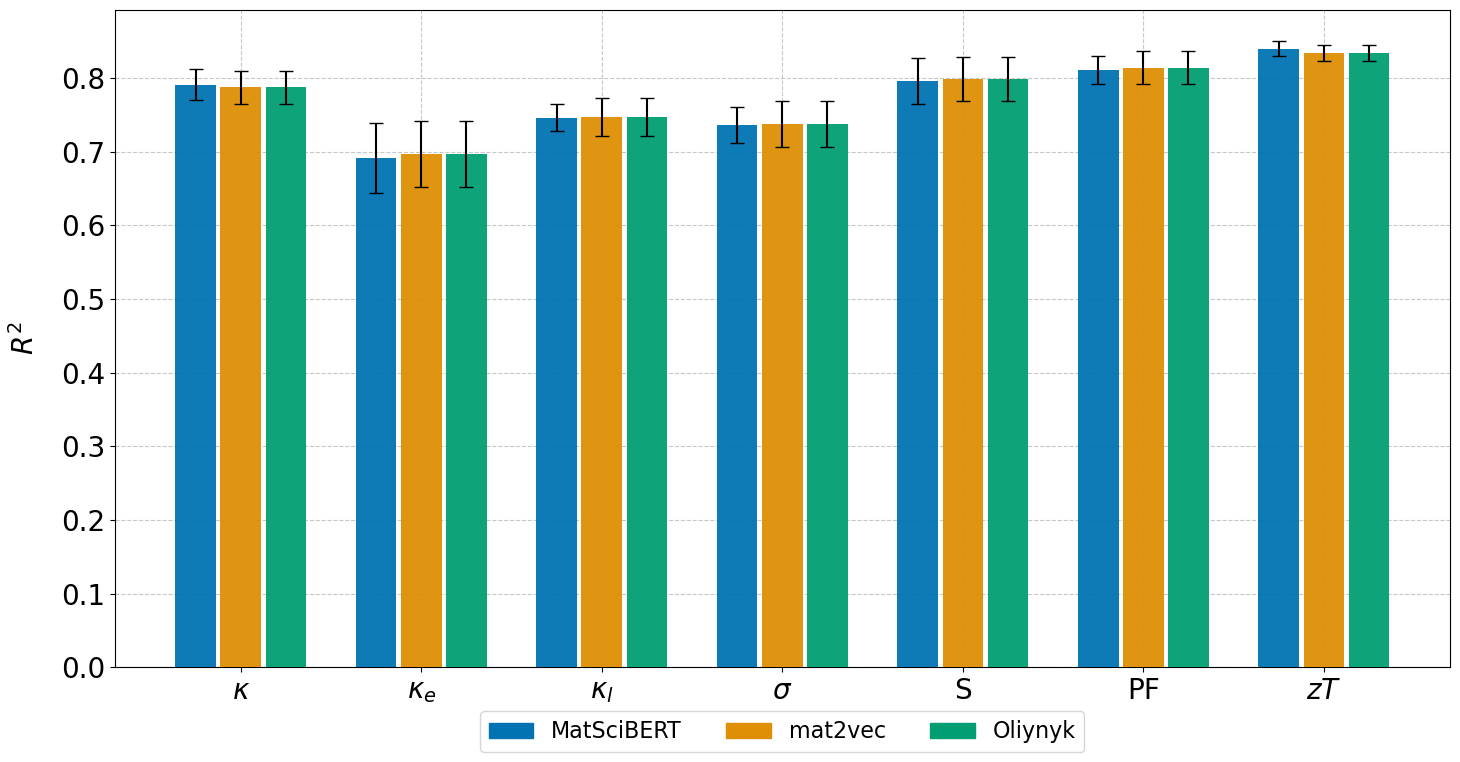

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import local_pkgs.proj_pkg.graph_settings

# Load YAML configuration
with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load the dataset
file_path = 'results/final/plot_results/consolidated_embeddings.csv'
data = pd.read_csv(file_path)

# Define model order and corresponding colors
model_order = [
    'MT CrabNet matscibert concat_at_input', 'MT CrabNet mat2vec concat_at_input', 'MT CrabNet oliynyk concat_at_input'
]

renamed_models = [
    'MatSciBERT', 'mat2vec', 'Oliynyk'
]


property_order = list(config.keys())

palette = sns.color_palette("colorblind", len(model_order))
model_colors = dict(zip(model_order, palette))

# Filter data by model order
data = data[data['model_name'].isin(model_order)]
data['model_name'] = pd.Categorical(data['model_name'], categories=model_order, ordered=True)

# Sort data by property and model
data = data.sort_values(by=['property', 'model_name'])

# Create the plot
plt.figure(figsize=(15, 8))
plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0)

# Loop through properties to add bar plots
current_position = 0
positions = []  # To track bar positions for each property
property_labels = {}  # Dictionary to track positions of property short names

for prop in property_order:
    # Get data for the specific property
    prop_data = data[data['property'] == prop]
    
    # Add bar plot for the property
    bar_positions = range(current_position, current_position + len(prop_data))
    plt.bar(
        bar_positions, 
        prop_data['r2_mean'], 
        color=[model_colors[model] for model in prop_data['model_name']], 
        yerr=prop_data['r2_se'],
        capsize=5,
        width=0.9,
        alpha=0.95,
        zorder=3  # Bars above gridlines
    )
    
    # Record the middle position for the property label
    middle_position = current_position + len(prop_data) // 2
    property_labels[middle_position] = config[prop]['short_name']
    
    # Update positions
    positions.extend(bar_positions)
    
    # Update current position, adding a gap for the next property
    current_position += len(prop_data) + 1  # Adding a gap between properties

# Set x-tick labels
plt.xticks(list(property_labels.keys()), list(property_labels.values()), ha='center', fontsize=20)

# y ticks
plt.yticks(fontsize=20)

# Rotate y-label
plt.ylabel(r"$R^2$", fontsize=20, labelpad=15)  # Rotate ylabel 90° clockwise


# Add legend outside the plot
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in palette]
plt.legend(
    handles, renamed_models, loc="upper center", 
    bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=16
)

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig("figures/hyperparams_comparison_b.pdf", bbox_inches="tight")
plt.show()

## ST CrabNet Vs. Baselines

In [ ]:
import local_pkgs.proj_pkg.ml_plots as mplots
import os
import pandas as pd
import yaml
import local_pkgs.proj_pkg.preprocessing as preprocess
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np


with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

seeds = [1, 42, 88, 123, 1201]

In [ ]:
file_1 = 'results/final/RF_results.csv'
file_2 = 'results/final/DopNet_results_ratio10.csv'
file_3 = 'results/final/ST_results.csv'

df_1 = pd.read_csv(file_1)
df_2 = pd.read_csv(file_2)
df_3 = pd.read_csv(file_3)

df = pd.concat([df_1, df_2, df_3], ignore_index=True)

# df.to_csv('results/final/plot_results/consolidated_st.csv', index=False)

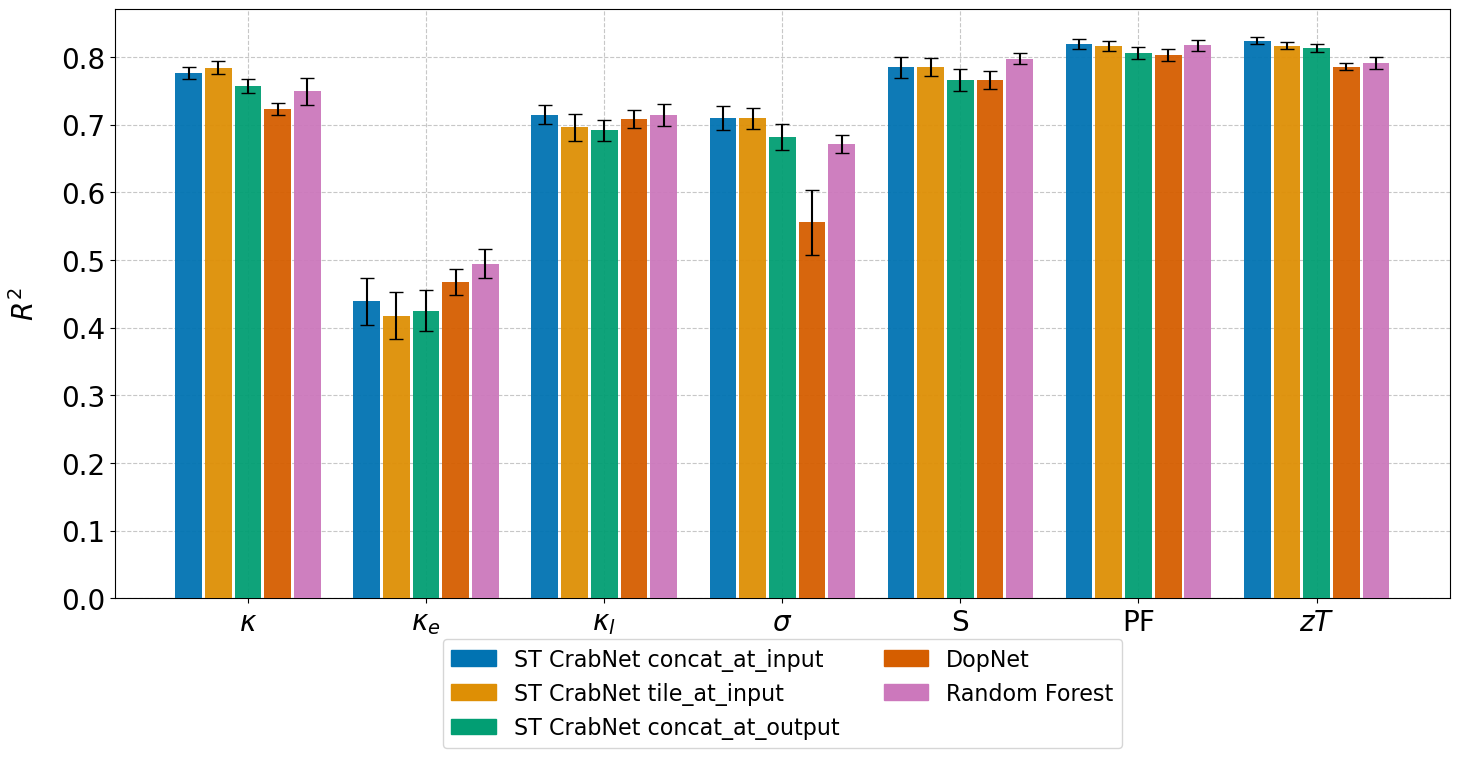

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import local_pkgs.proj_pkg.graph_settings

# Load YAML configuration
with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load the dataset
file_path = 'results/final/plot_results/consolidated_st.csv'
data = pd.read_csv(file_path)

model_order = [
    "ST CrabNet concat_at_input", "ST CrabNet tile_at_input", 
    "ST CrabNet concat_at_output", "DopNet", "Random Forest"
]


property_order = list(config.keys())

palette = sns.color_palette("colorblind", len(model_order))
model_colors = dict(zip(model_order, palette))

# Filter data by model order
data = data[data['model_name'].isin(model_order)]
data['model_name'] = pd.Categorical(data['model_name'], categories=model_order, ordered=True)

# Sort data by property and model
data = data.sort_values(by=['property', 'model_name'])

# Create the plot
plt.figure(figsize=(15, 8))
plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0)

# Loop through properties to add bar plots
current_position = 0
positions = []  # To track bar positions for each property
property_labels = {}  # Dictionary to track positions of property short names

for prop in property_order:
    # Get data for the specific property
    prop_data = data[data['property'] == prop]
    
    # Add bar plot for the property
    bar_positions = range(current_position, current_position + len(prop_data))
    plt.bar(
        bar_positions, 
        prop_data['r2_mean'], 
        color=[model_colors[model] for model in prop_data['model_name']], 
        yerr=prop_data['r2_se'],
        capsize=5,
        width=0.9,
        alpha=0.95,
        zorder=3  # Bars above gridlines
    )
    
    # Record the middle position for the property label
    middle_position = current_position + len(prop_data) // 2
    property_labels[middle_position] = config[prop]['short_name']
    
    # Update positions
    positions.extend(bar_positions)
    
    # Update current position, adding a gap for the next property
    current_position += len(prop_data) + 1  # Adding a gap between properties

# Set x-tick labels
plt.xticks(list(property_labels.keys()), list(property_labels.values()), ha='center', fontsize=20)

# y ticks
plt.yticks(fontsize=20)

# Rotate y-label
plt.ylabel(r"$R^2$", fontsize=20, labelpad=15)  # Rotate ylabel 90° clockwise


# Add legend outside the plot
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in palette]
plt.legend(
    handles, model_order, loc="upper center", 
    bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=16
)

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig("figures/st_crabnet_versus_baselines.pdf", bbox_inches="tight")
plt.show()

# Parity Plots

In [2]:
import local_pkgs.proj_pkg.ml_plots as mplots
import os
import pandas as pd
import yaml
import local_pkgs.proj_pkg.preprocessing as preprocess
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

yaml_file = "thermoelectric_properties.yaml"


with open(yaml_file, "r", encoding="utf-8") as f:
    props = yaml.safe_load(f)

seeds = [1, 42, 88, 123, 1201]

sns.set_style("whitegrid")

/Users/drago/Anaconda/anaconda3/envs/mt-crabnet_localenv/lib/python3.10/site-packages/matminer/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## MT CrabNet 
Concat_at_attn, concat_at_input

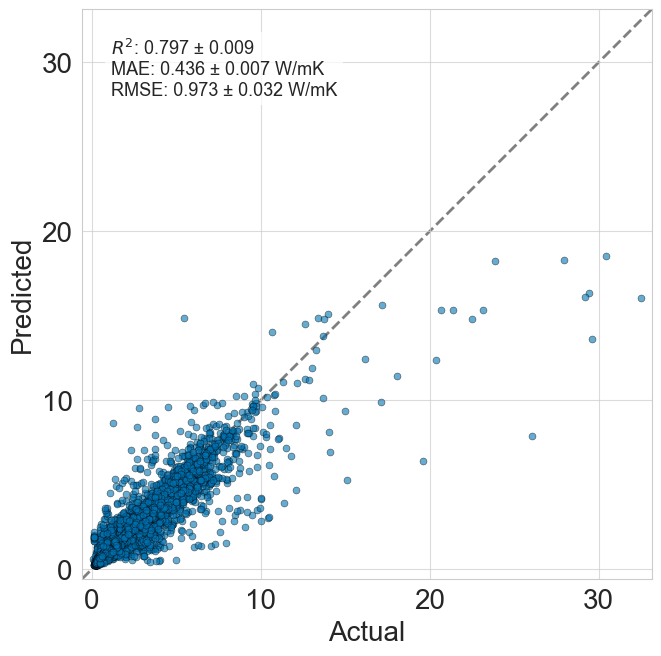

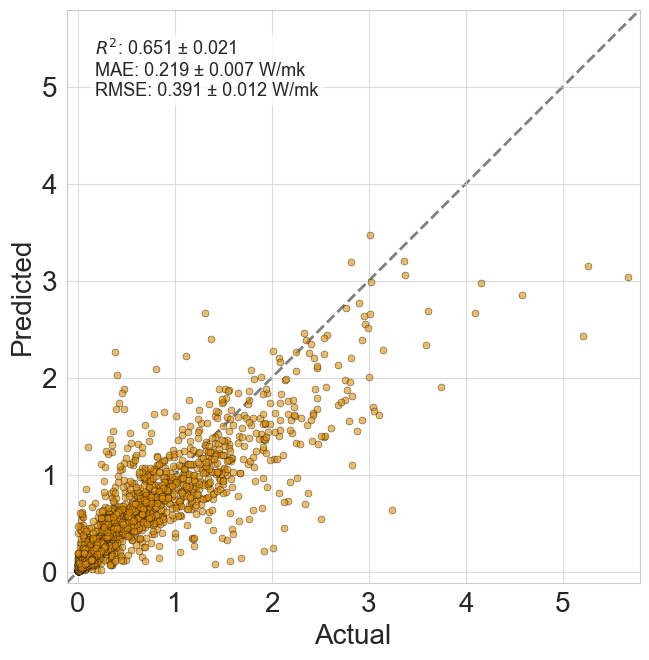

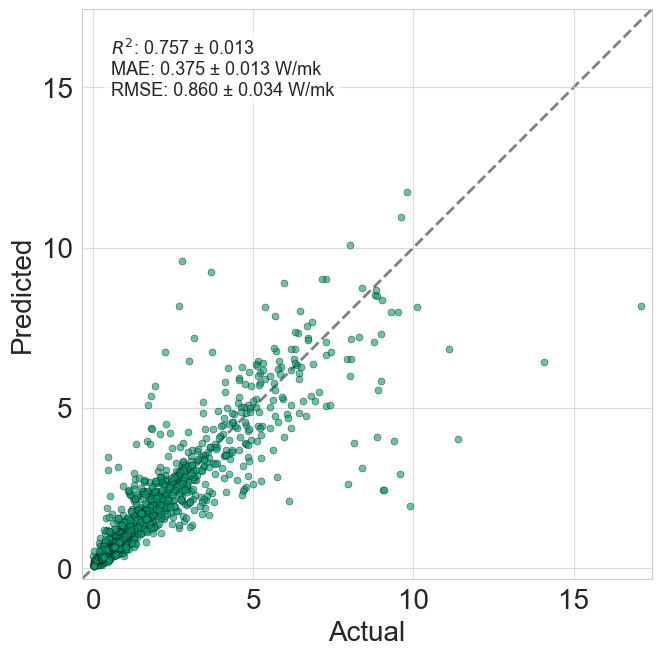

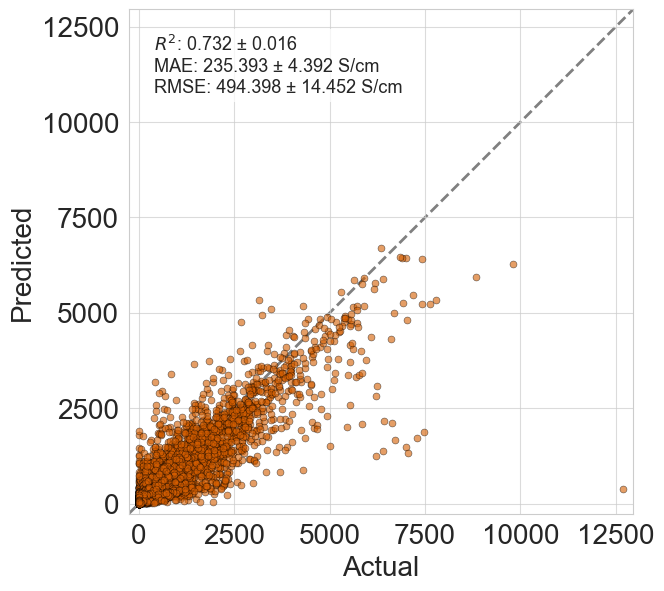

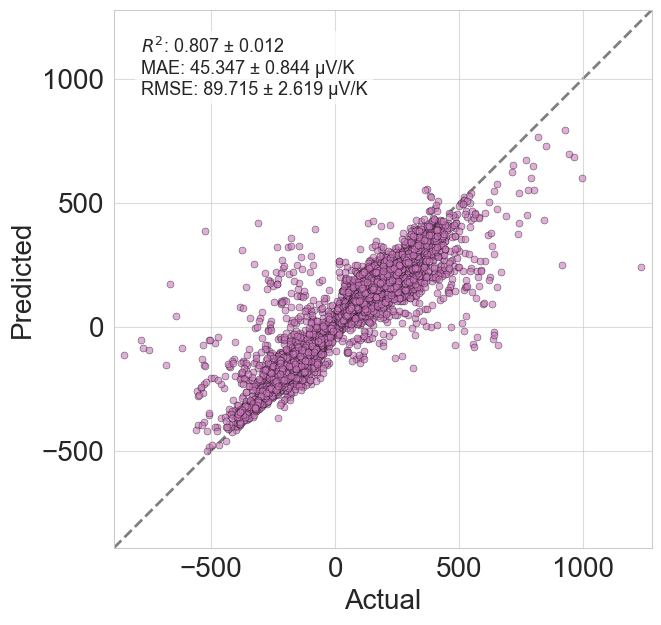

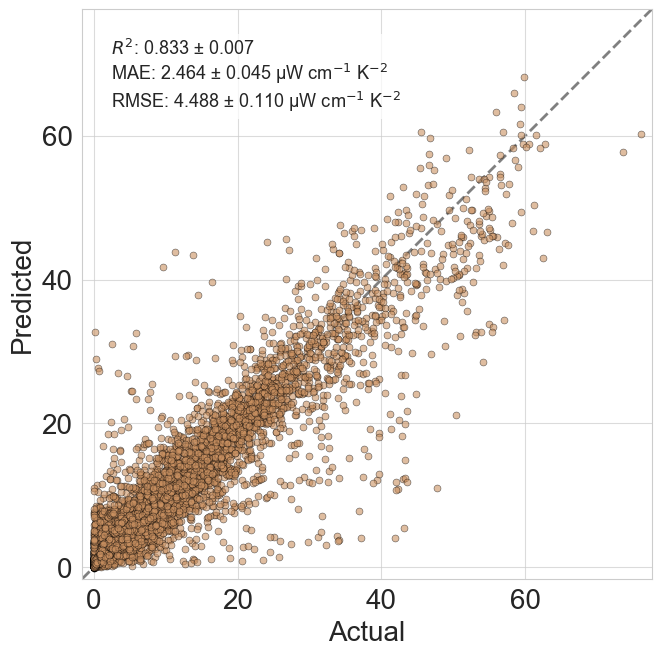

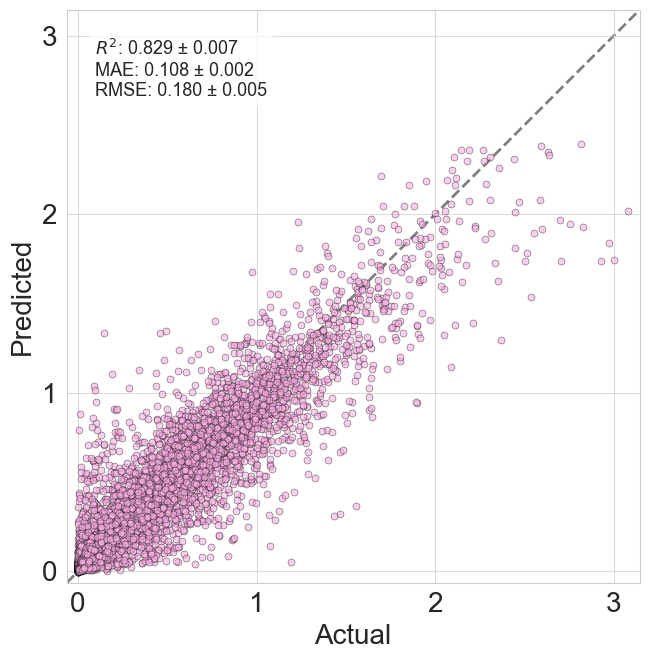

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'MTCrabNet_concat_at_input_onehotappendconcat_at_attn'

actual_col = 'Actual'

predict_col = 'Predicted'

k_col = 'K_fold'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        csv_path = os.path.join(f'results/final/MT-CrabNet/MultiTask_RobustL2_matscibert_concat_at_input_onehotappendconcat_at_attn_5splits_seed{seed}.csv')
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df[df['Property'] == v['column_name']]
        df = df.sort_index(ascending=True)
        actuals.append(df[actual_col].values)
        predictions.append(df[predict_col].values)

        if "K_Fold" in df.columns:
            fold_col = "K_Fold"
        elif "K_fold" in df.columns:
            fold_col = "K_fold"
        else:
            fold_col = None

        for fold in sorted(df[fold_col].unique()):
            fold_df = df[df[fold_col] == fold]
            scores_r2.append(r2_score(fold_df[actual_col], fold_df[predict_col]))
            scores_mae.append(mean_absolute_error(fold_df[actual_col], fold_df[predict_col]))
            scores_rmse.append(np.sqrt(mean_squared_error(fold_df[actual_col], fold_df[predict_col])))


    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

concat_at_attn, tile_at_input

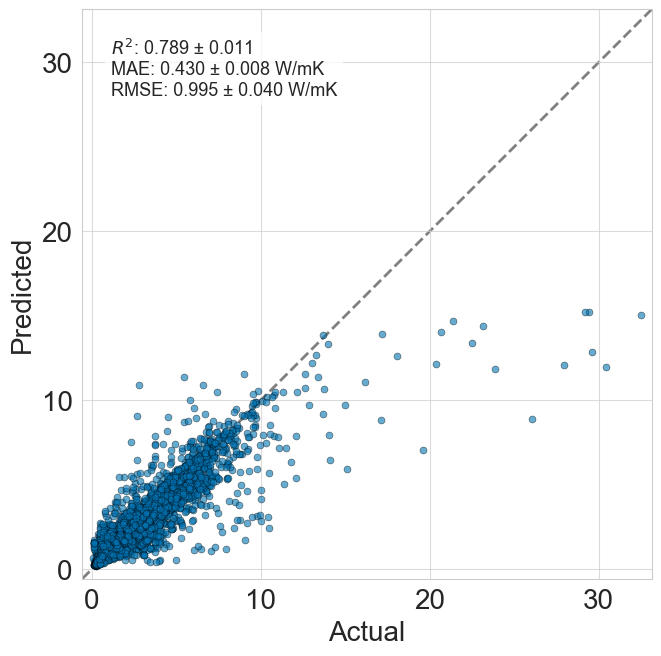

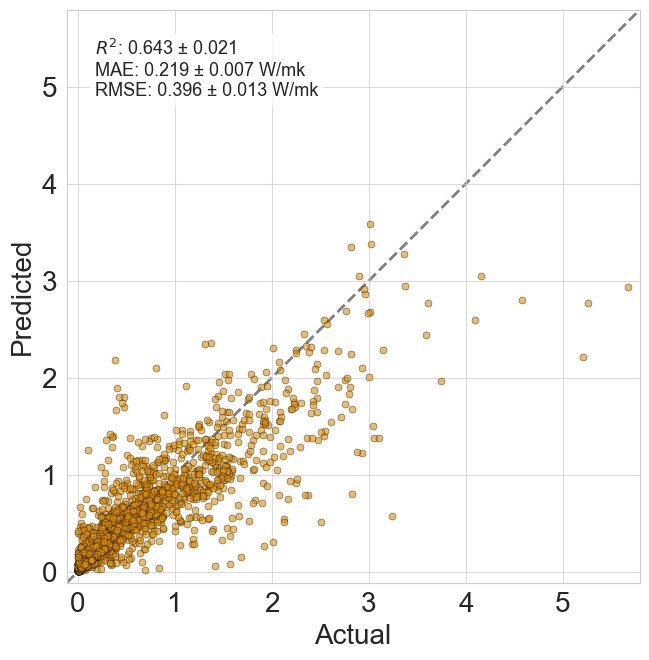

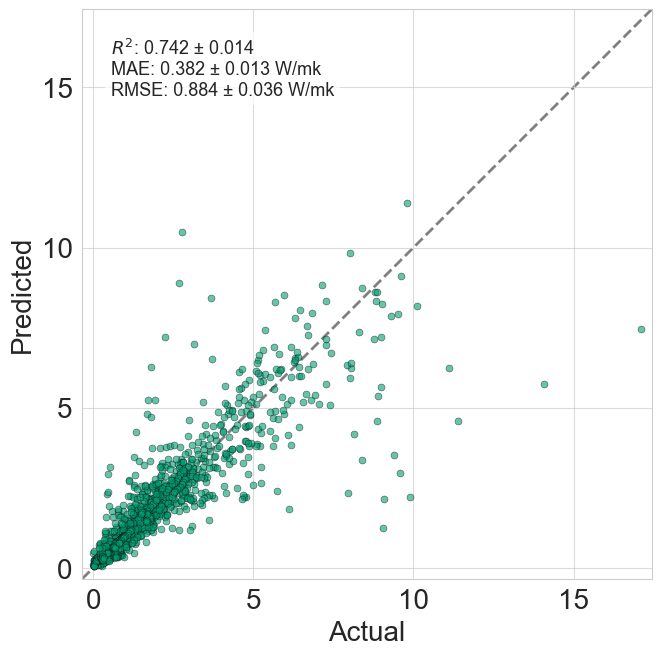

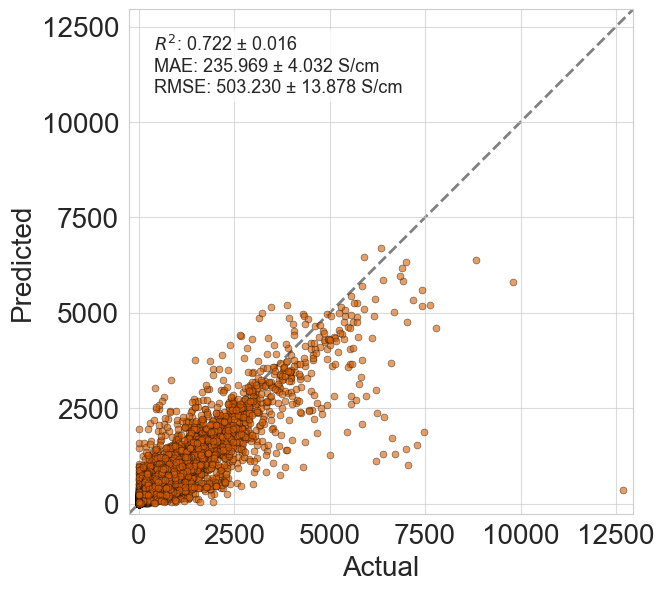

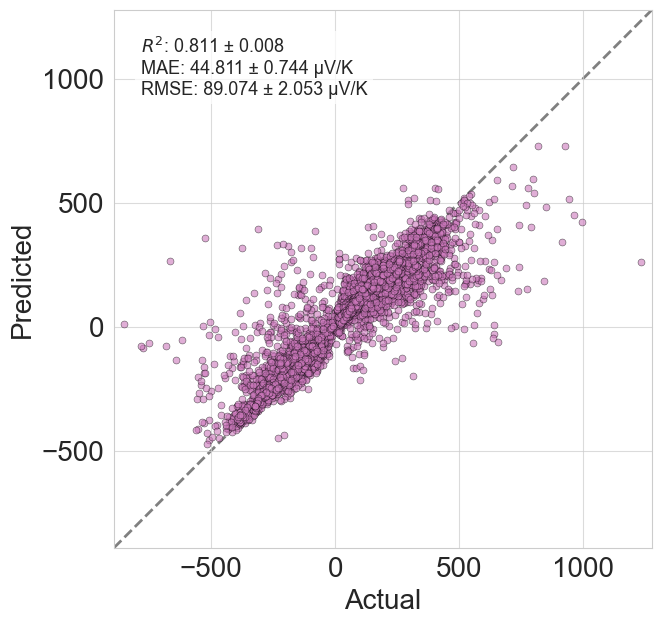

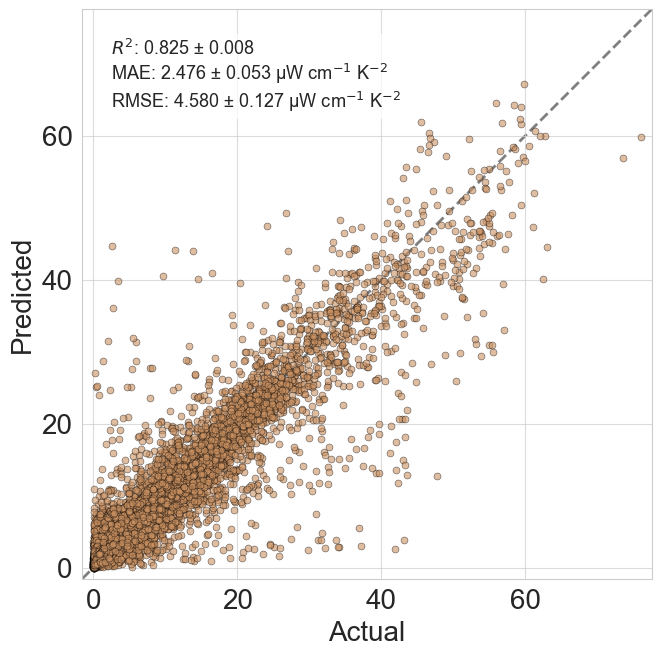

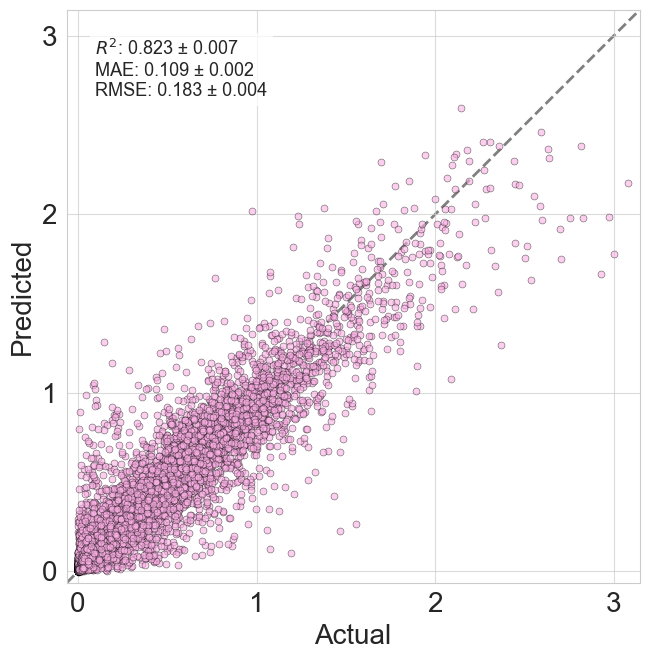

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'MTCrabNet_tile_at_input_onehotappendconcat_at_attn'

actual_col = 'Actual'

predict_col = 'Predicted'

k_col = 'K_fold'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        csv_path = os.path.join(f'results/final/MT-CrabNet/MultiTask_RobustL2_matscibert_tile_at_input_onehotappendconcat_at_attn_5splits_seed{seed}.csv')
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df[df['Property'] == v['column_name']]
        df = df.sort_index(ascending=True)
        actuals.append(df[actual_col].values)
        predictions.append(df[predict_col].values)

        if "K_Fold" in df.columns:
            fold_col = "K_Fold"
        elif "K_fold" in df.columns:
            fold_col = "K_fold"
        else:
            fold_col = None

        for fold in sorted(df[fold_col].unique()):
            fold_df = df[df[fold_col] == fold]
            scores_r2.append(r2_score(fold_df[actual_col], fold_df[predict_col]))
            scores_mae.append(mean_absolute_error(fold_df[actual_col], fold_df[predict_col]))
            scores_rmse.append(np.sqrt(mean_squared_error(fold_df[actual_col], fold_df[predict_col])))


    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

concat_at_attn, concat_at_output

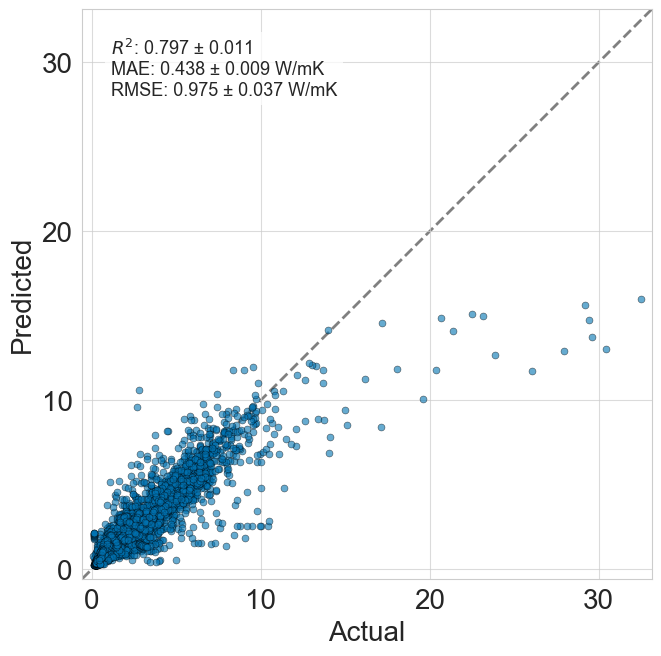

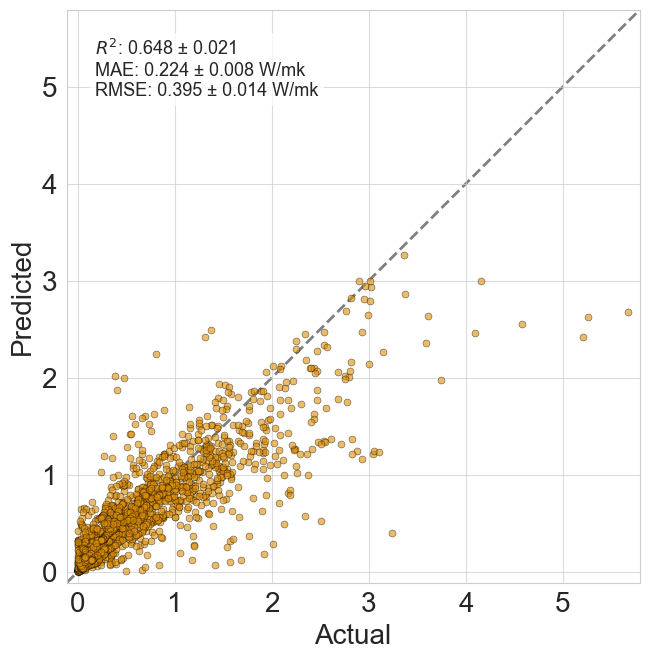

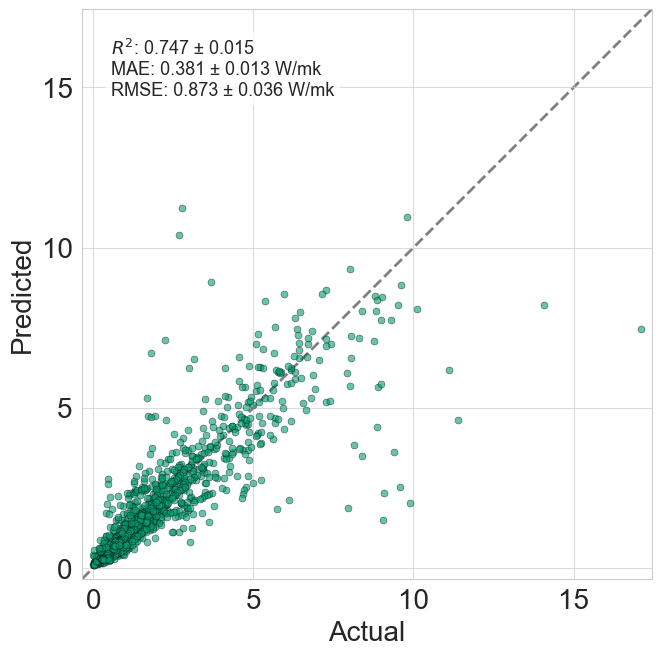

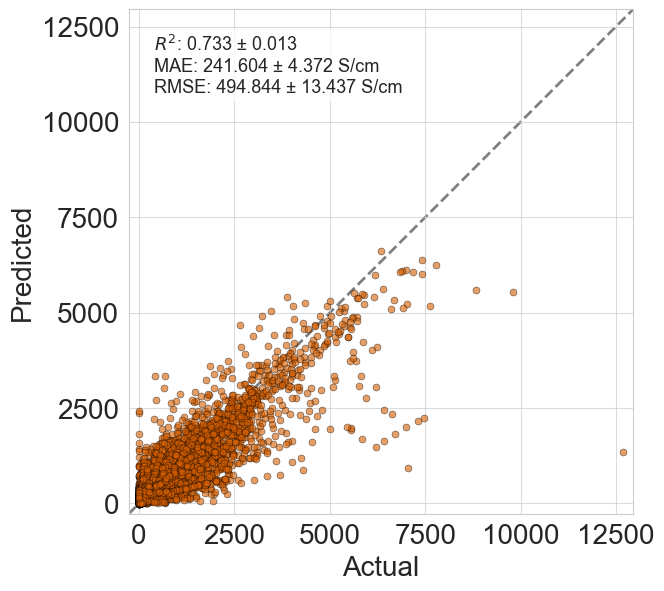

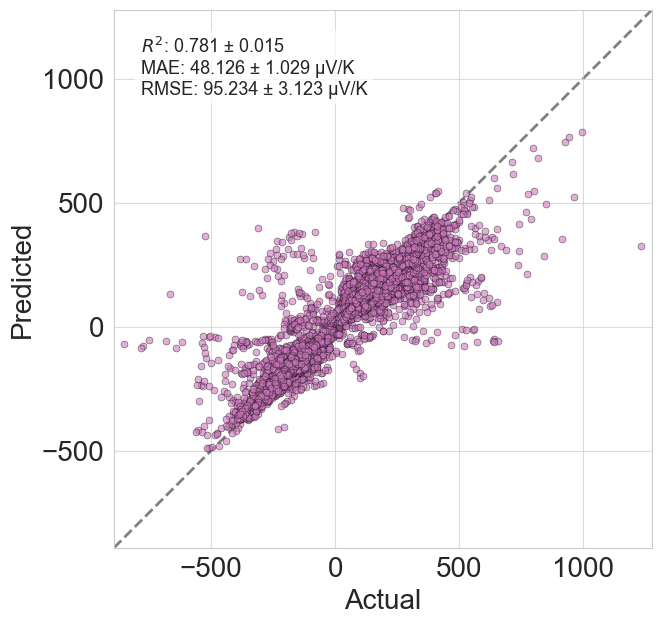

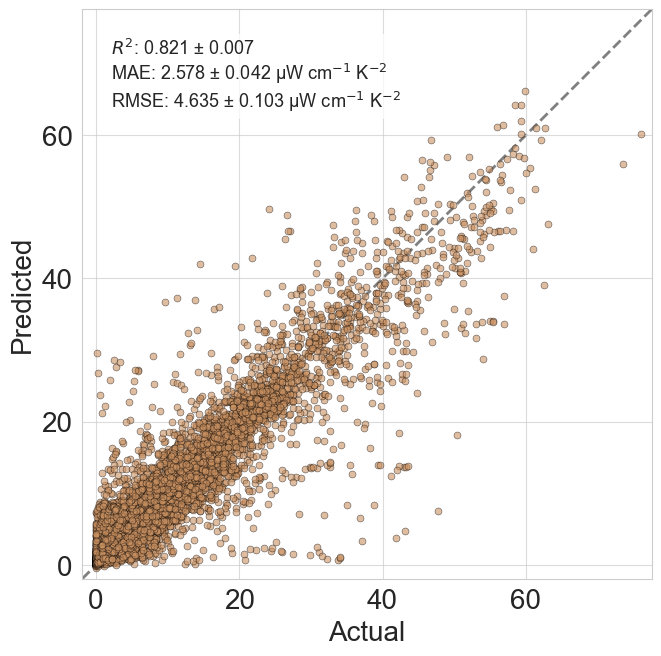

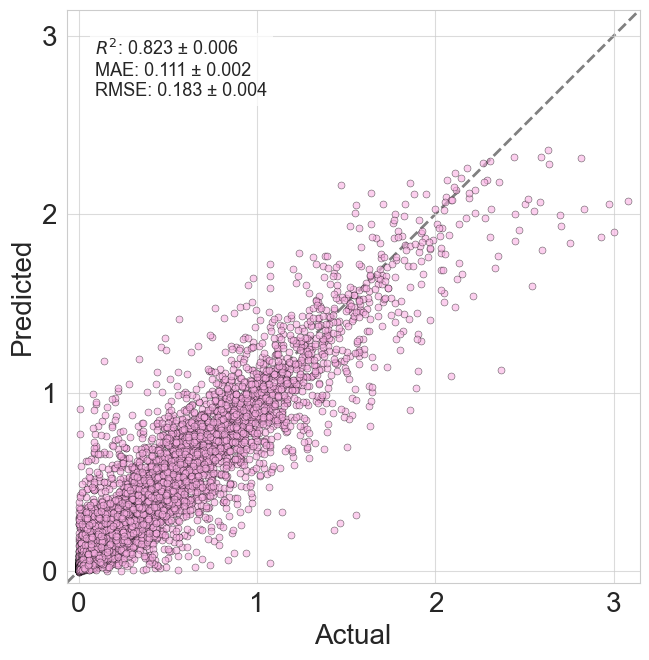

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'MTCrabNet_concat_at_output_onehotappendconcat_at_attn'

actual_col = 'Actual'

predict_col = 'Predicted'

k_col = 'K_fold'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        csv_path = os.path.join(f'results/final/MT-CrabNet/MultiTask_RobustL2_matscibert_concat_at_output_onehotappendconcat_at_attn_5splits_seed{seed}.csv')
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df[df['Property'] == v['column_name']]
        df = df.sort_index(ascending=True)
        actuals.append(df[actual_col].values)
        predictions.append(df[predict_col].values)

        if "K_Fold" in df.columns:
            fold_col = "K_Fold"
        elif "K_fold" in df.columns:
            fold_col = "K_fold"
        else:
            fold_col = None

        for fold in sorted(df[fold_col].unique()):
            fold_df = df[df[fold_col] == fold]
            scores_r2.append(r2_score(fold_df[actual_col], fold_df[predict_col]))
            scores_mae.append(mean_absolute_error(fold_df[actual_col], fold_df[predict_col]))
            scores_rmse.append(np.sqrt(mean_squared_error(fold_df[actual_col], fold_df[predict_col])))


    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

## RF

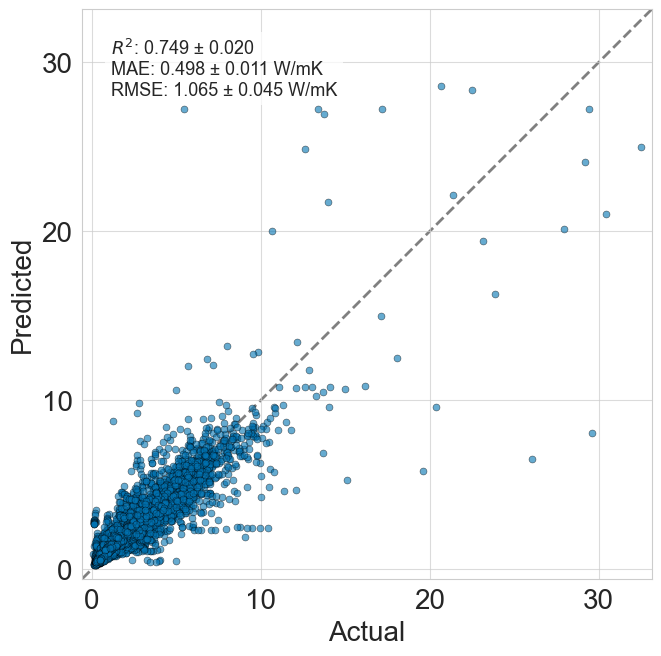

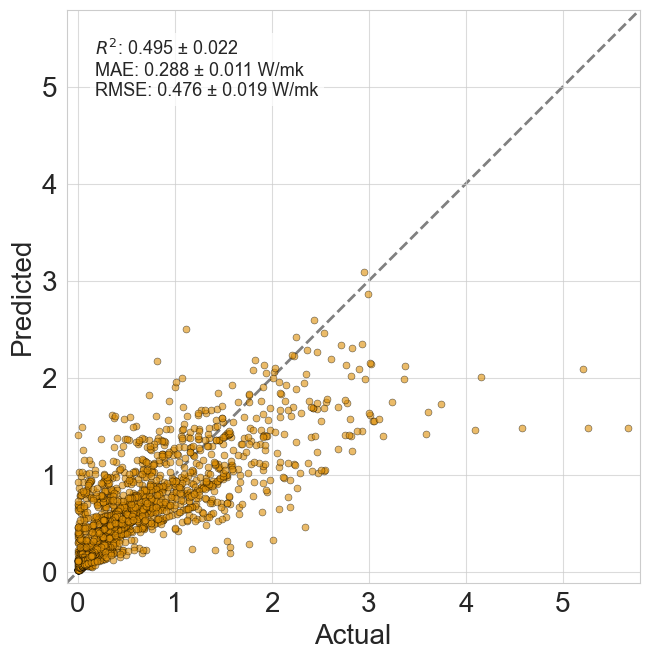

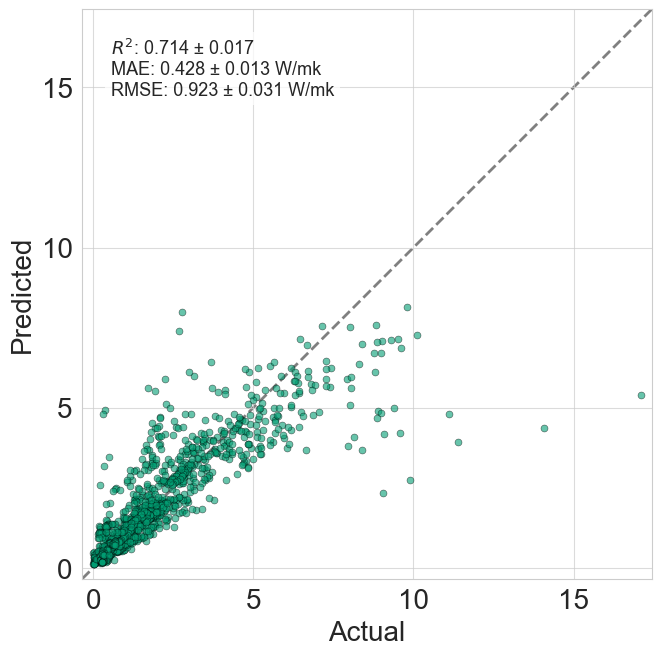

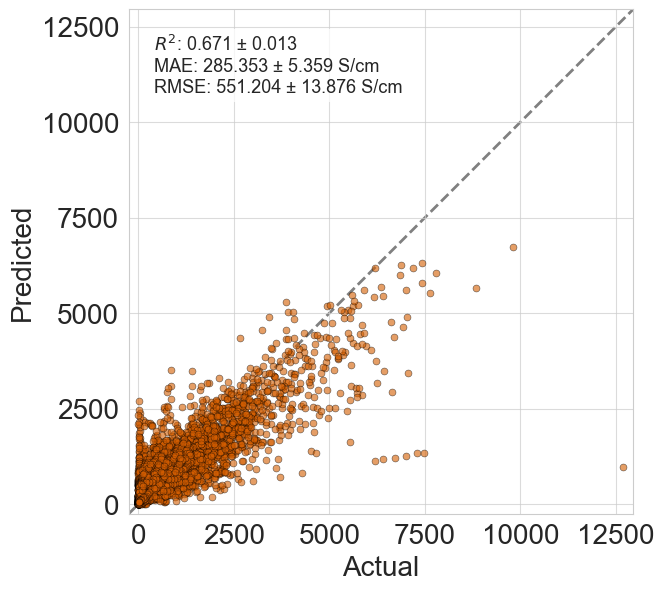

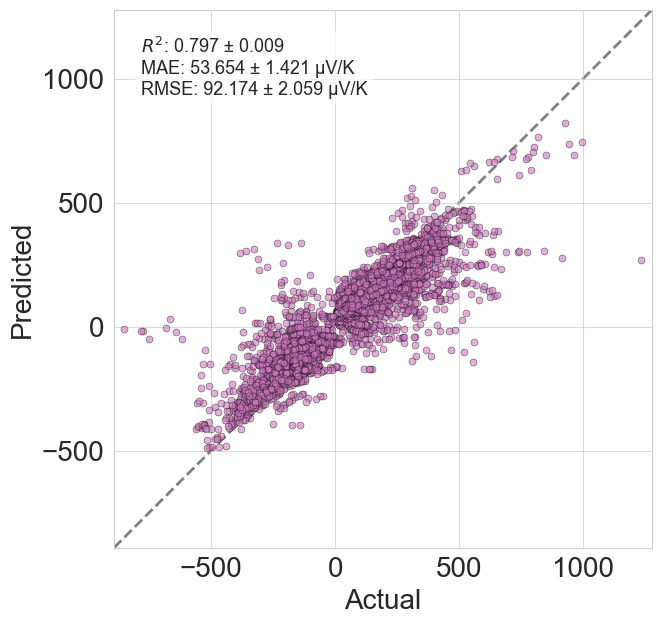

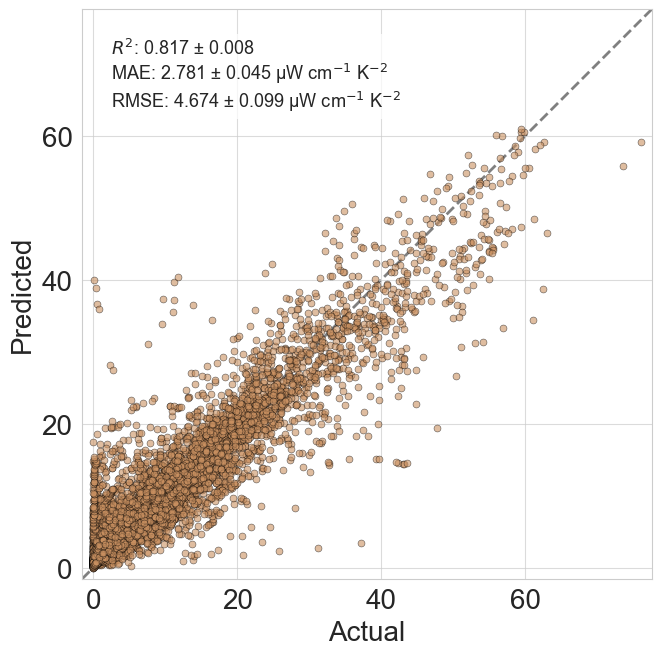

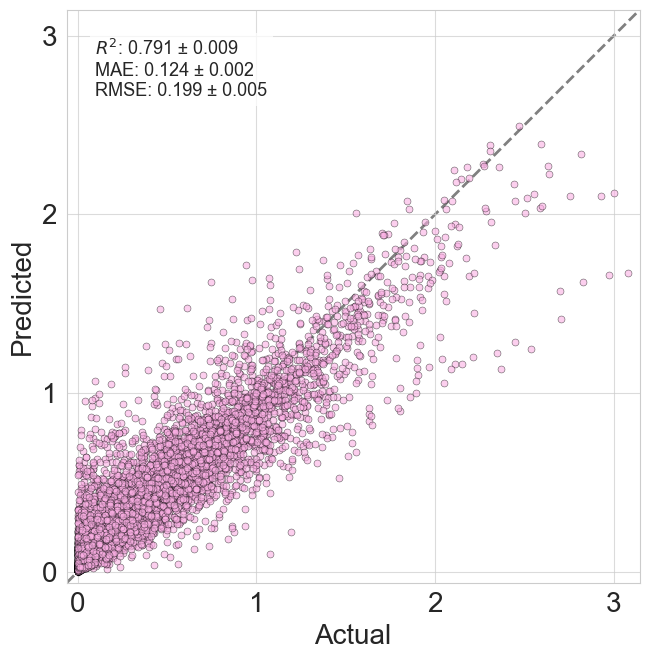

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'RF'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        folder = f"Seed{seed}_OuterFold5_NoScaler_Direct Composition_{prop_key}"
        csv_path = os.path.join('results/final/Random Forest', folder, "actual_vs_predicted.csv")
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df.sort_index(ascending=True)
        actuals.append(df["Actual"].values)
        predictions.append(df["Predicted"].values)

        if "K_Fold" in df.columns:
            fold_col = "K_Fold"
        elif "K_fold" in df.columns:
            fold_col = "K_fold"
        else:
            fold_col = None

        if fold_col:
            for fold in sorted(df[fold_col].unique()):
                fold_df = df[df[fold_col] == fold]
                scores_r2.append(r2_score(fold_df["Actual"], fold_df["Predicted"]))
                scores_mae.append(mean_absolute_error(fold_df["Actual"], fold_df["Predicted"]))
                scores_rmse.append(np.sqrt(mean_squared_error(fold_df["Actual"], fold_df["Predicted"])))
        else:
            scores_r2.append(r2_score(df["Actual"], df["Predicted"]))
            scores_mae.append(mean_absolute_error(df["Actual"], df["Predicted"]))
            scores_rmse.append(np.sqrt(mean_squared_error(df["Actual"], df["Predicted"])))

    if not predictions:
        continue

    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

## DopNet

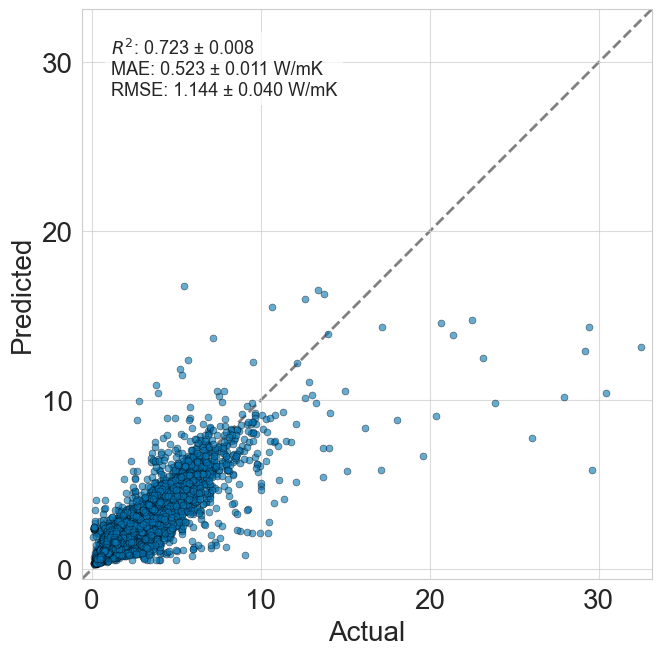

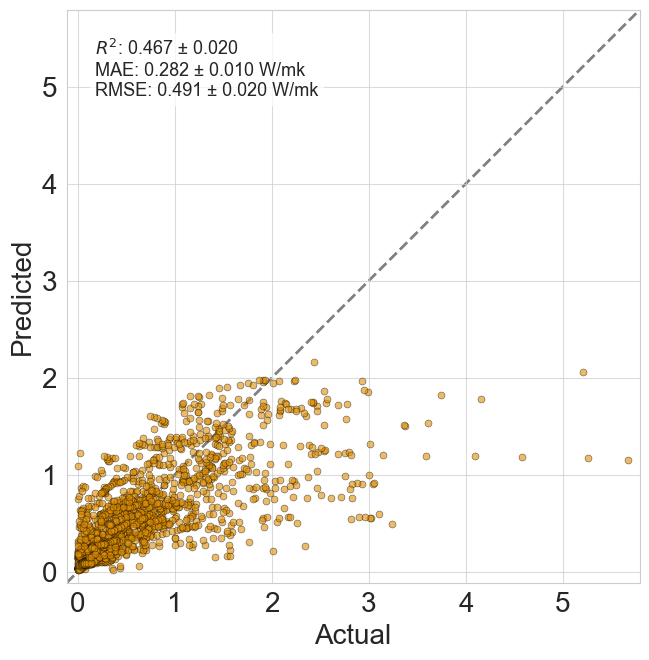

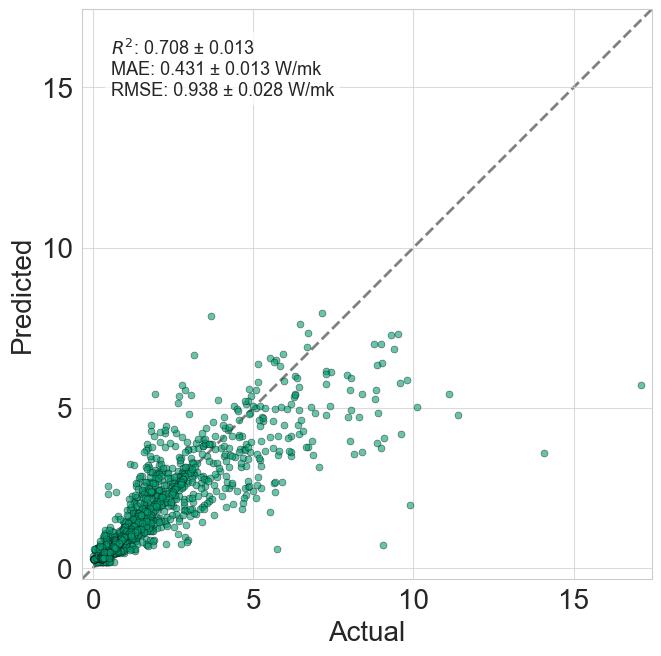

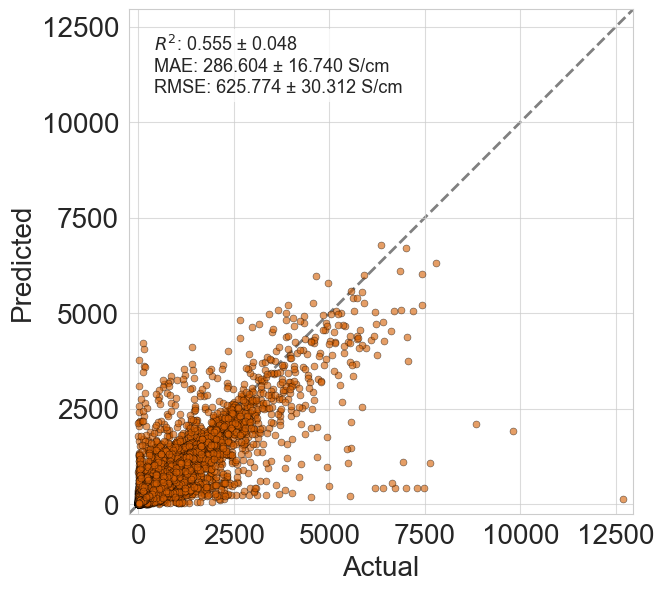

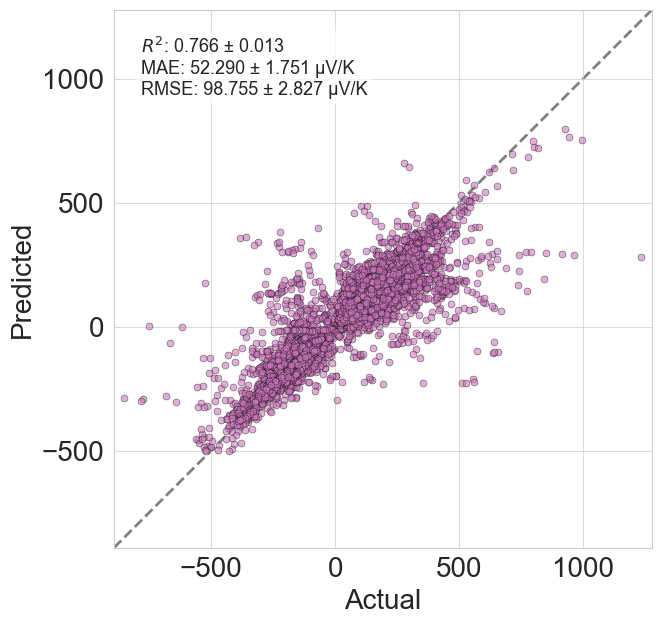

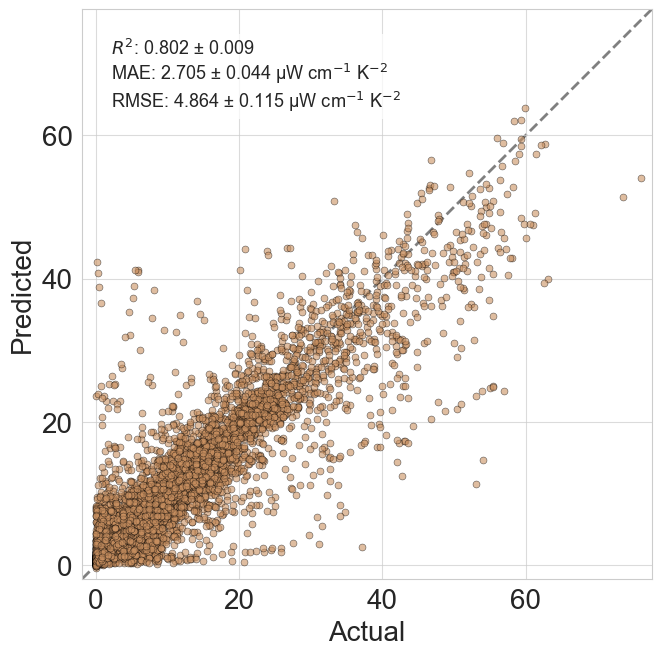

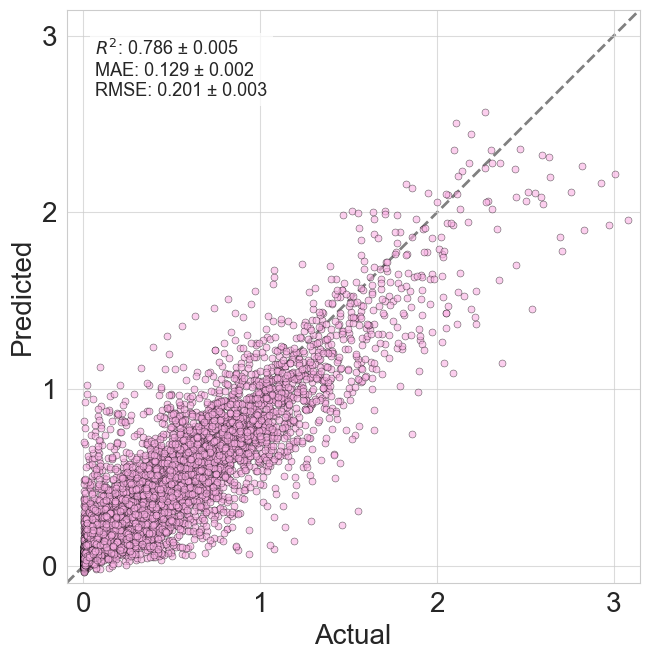

In [4]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'DopNet'

actual_col = 'target'

predict_col = 'prediction'

k_col = 'K_fold'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        folder = f"Seed{seed}_OuterFold5_NoScaler_Direct Composition_{prop_key}"
        csv_path = os.path.join(f'results/final/DopNet/{prop_key}_preds_CompKFold_dopnet_ratio10_{seed}.csv')
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df.sort_index(ascending=True)
        actuals.append(df[actual_col].values)
        predictions.append(df[predict_col].values)

        for fold in sorted(df[k_col].unique()):
            fold_df = df[df[k_col] == fold]
            scores_r2.append(r2_score(fold_df[actual_col], fold_df[predict_col]))
            scores_mae.append(mean_absolute_error(fold_df[actual_col], fold_df[predict_col]))
            scores_rmse.append(np.sqrt(mean_squared_error(fold_df[actual_col], fold_df[predict_col])))

    if not predictions:
        continue

    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

## ST CrabNet 
concat at input

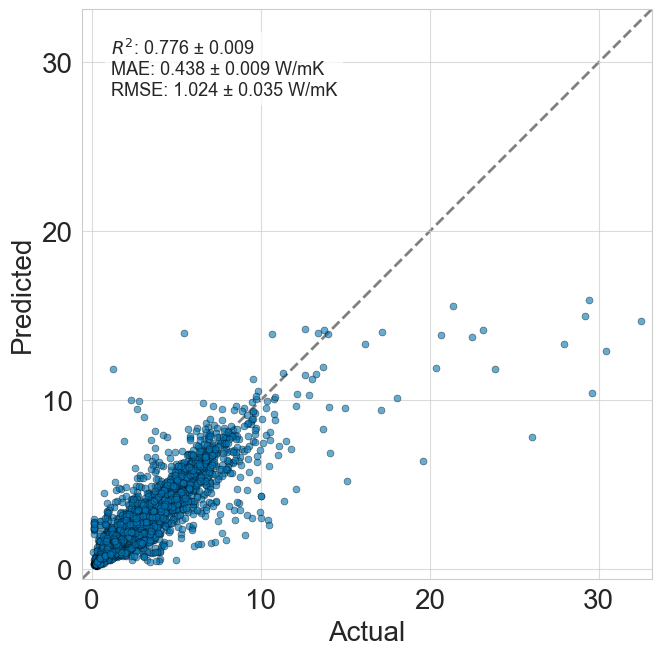

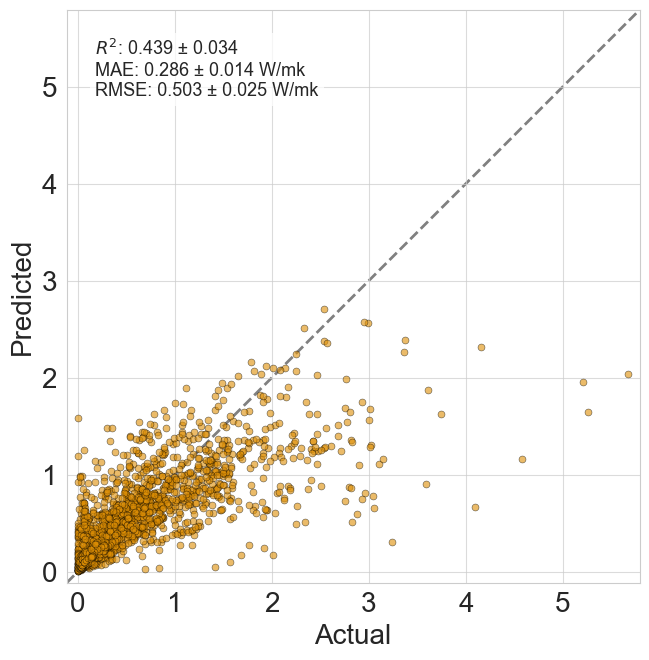

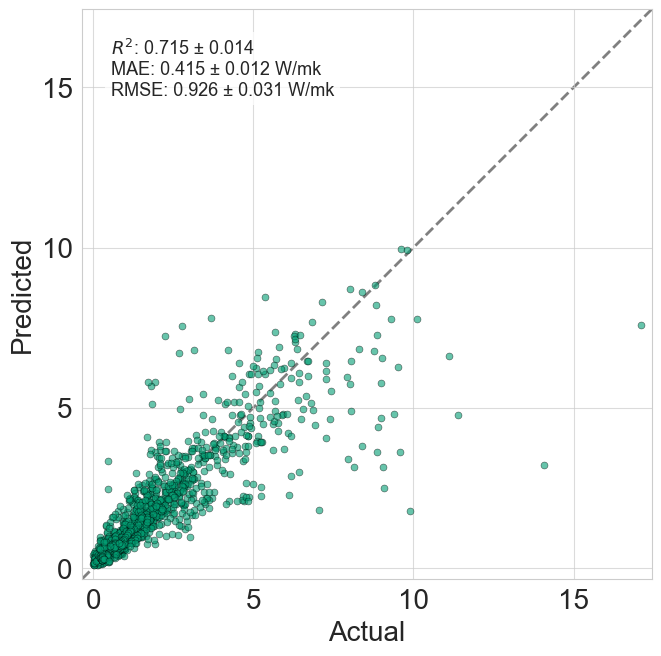

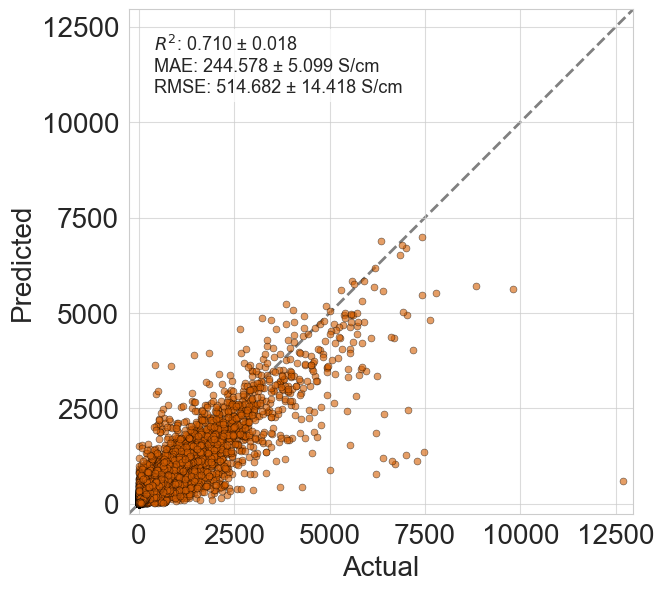

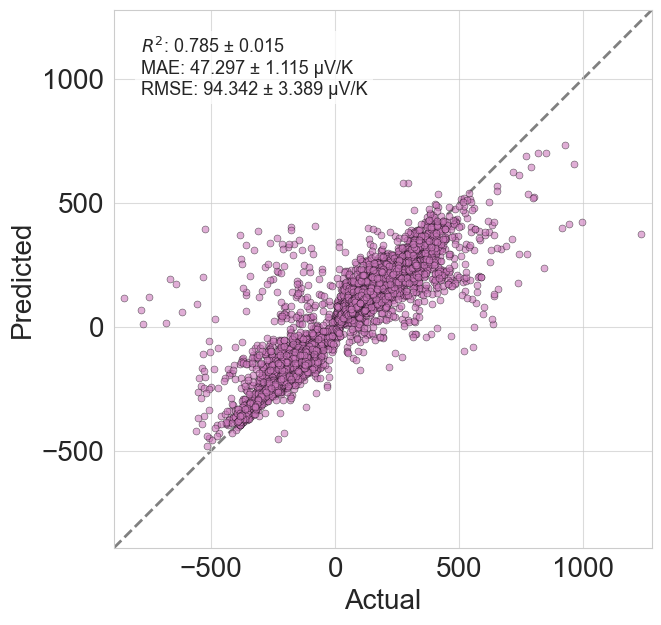

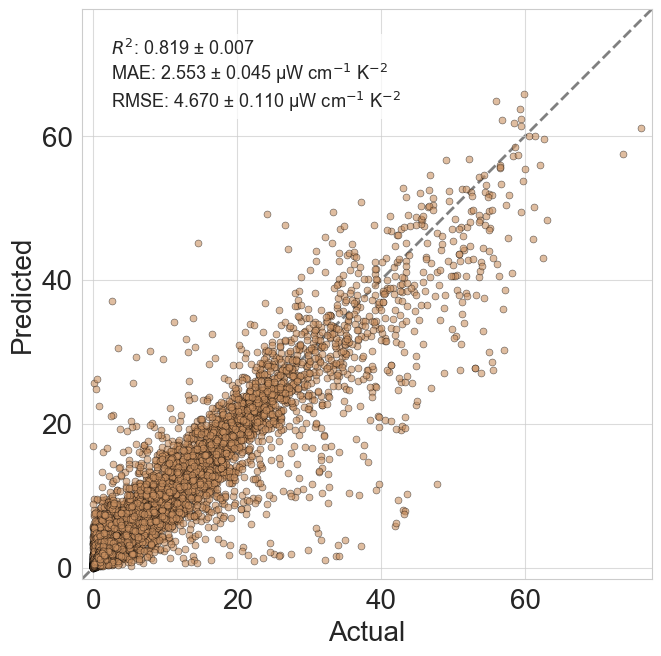

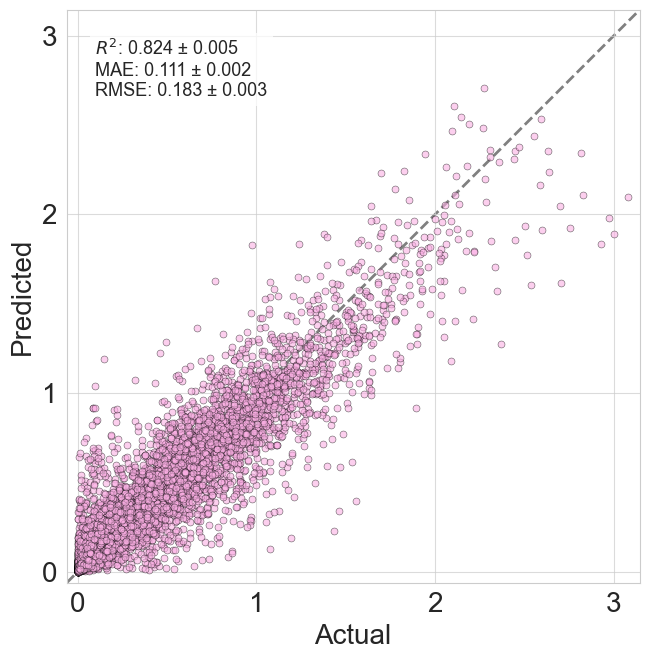

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'STCrabNet_concat_at_input'

actual_col = 'Actual'

predict_col = 'Predicted'

k_col = 'K_fold'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        csv_path = os.path.join(f'results/final/ST-CrabNet/SingleTask_StandardTransform_{prop_key}_RobustL2_DopedCrab_matscibert_concat_at_input_5splits_Seed{seed}.csv')
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df.sort_index(ascending=True)
        actuals.append(df[actual_col].values)
        predictions.append(df[predict_col].values)

        if "K_Fold" in df.columns:
            fold_col = "K_Fold"
        elif "K_fold" in df.columns:
            fold_col = "K_fold"
        else:
            fold_col = None

        for fold in sorted(df[fold_col].unique()):
            fold_df = df[df[fold_col] == fold]
            scores_r2.append(r2_score(fold_df[actual_col], fold_df[predict_col]))
            scores_mae.append(mean_absolute_error(fold_df[actual_col], fold_df[predict_col]))
            scores_rmse.append(np.sqrt(mean_squared_error(fold_df[actual_col], fold_df[predict_col])))


    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

tile at input

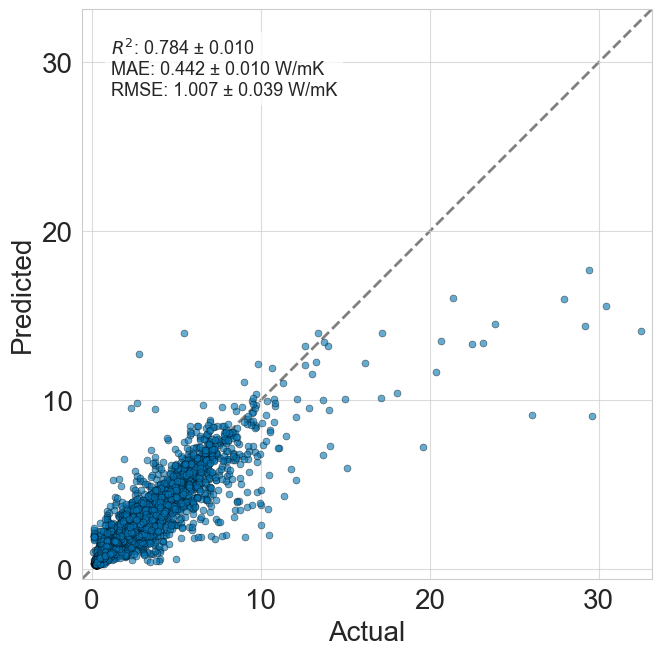

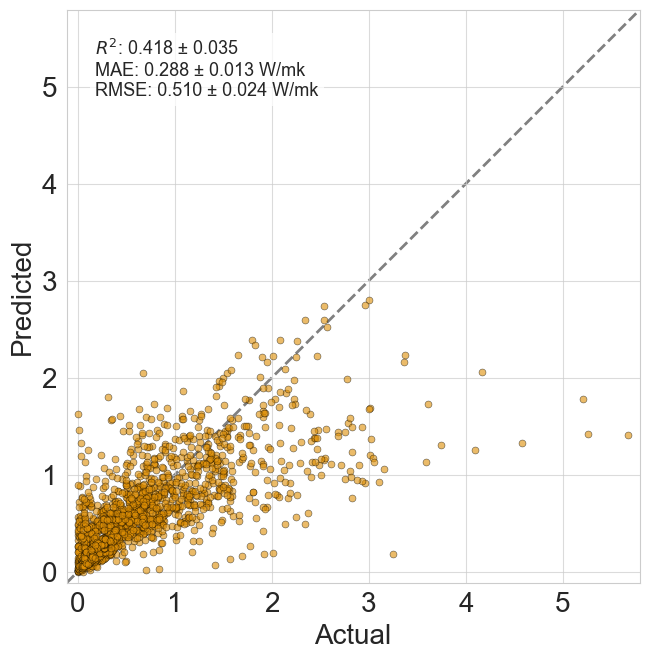

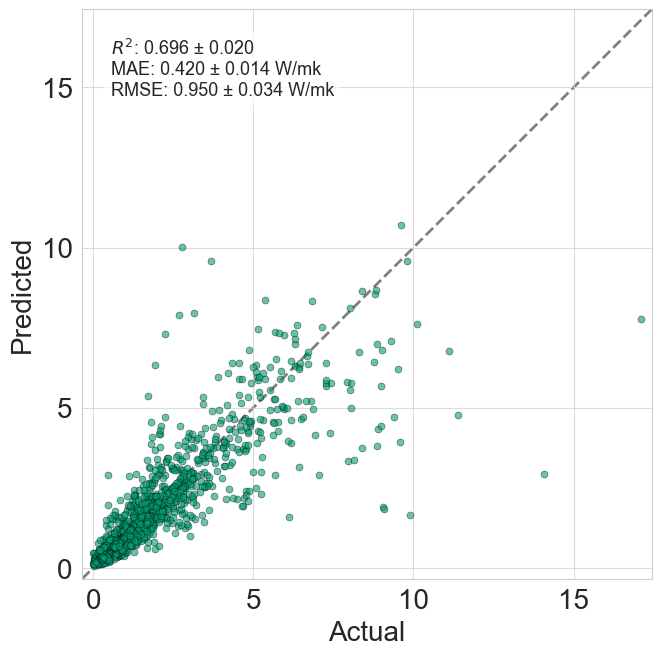

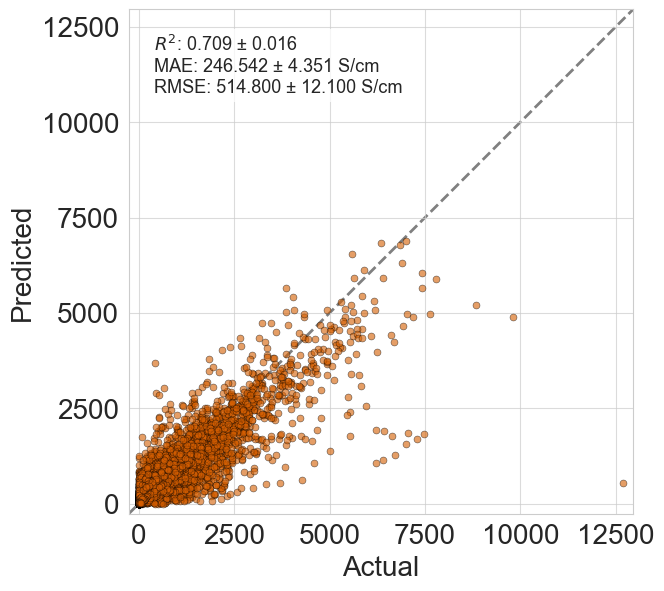

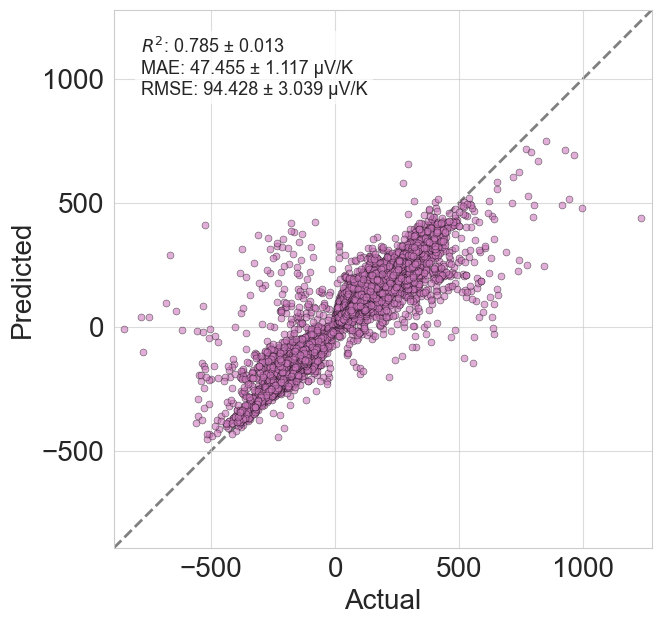

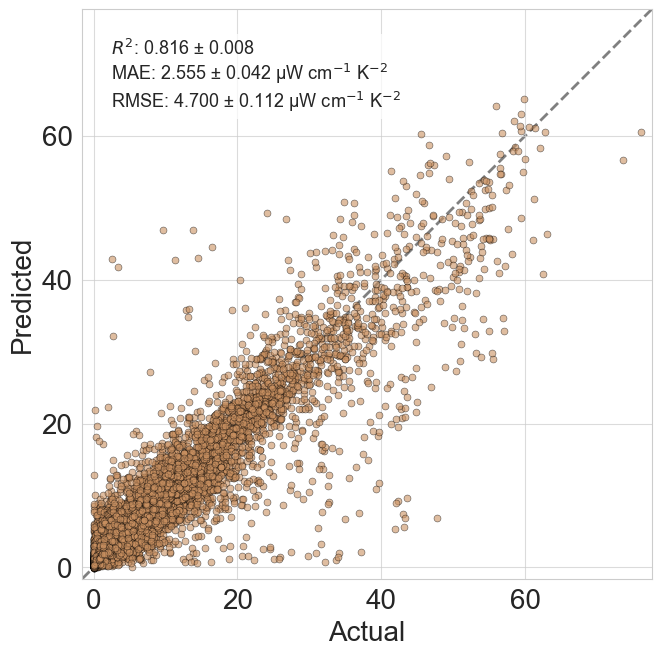

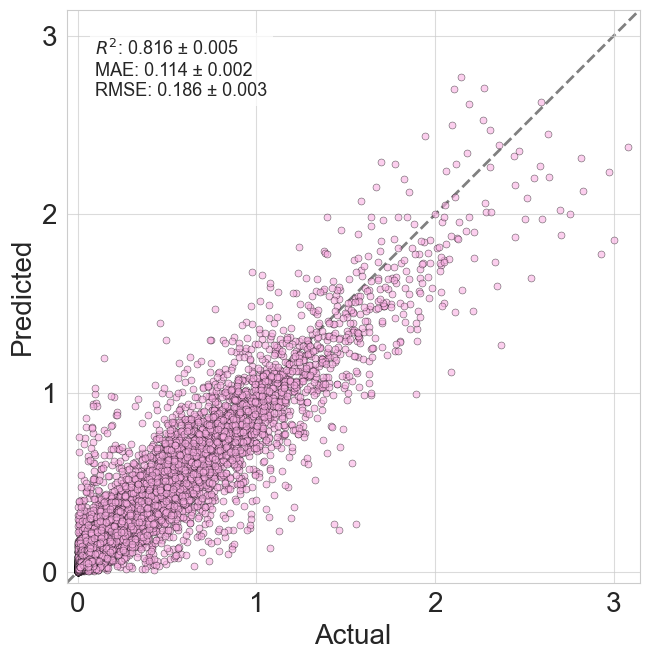

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'STCrabNet_tile_at_input'

actual_col = 'Actual'

predict_col = 'Predicted'

k_col = 'K_fold'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        csv_path = os.path.join(f'results/final/ST-CrabNet/SingleTask_StandardTransform_{prop_key}_RobustL2_DopedCrab_matscibert_tile_at_input_5splits_Seed{seed}.csv')
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df.sort_index(ascending=True)
        actuals.append(df[actual_col].values)
        predictions.append(df[predict_col].values)

        if "K_Fold" in df.columns:
            fold_col = "K_Fold"
        elif "K_fold" in df.columns:
            fold_col = "K_fold"
        else:
            fold_col = None

        for fold in sorted(df[fold_col].unique()):
            fold_df = df[df[fold_col] == fold]
            scores_r2.append(r2_score(fold_df[actual_col], fold_df[predict_col]))
            scores_mae.append(mean_absolute_error(fold_df[actual_col], fold_df[predict_col]))
            scores_rmse.append(np.sqrt(mean_squared_error(fold_df[actual_col], fold_df[predict_col])))


    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

concat_at_output

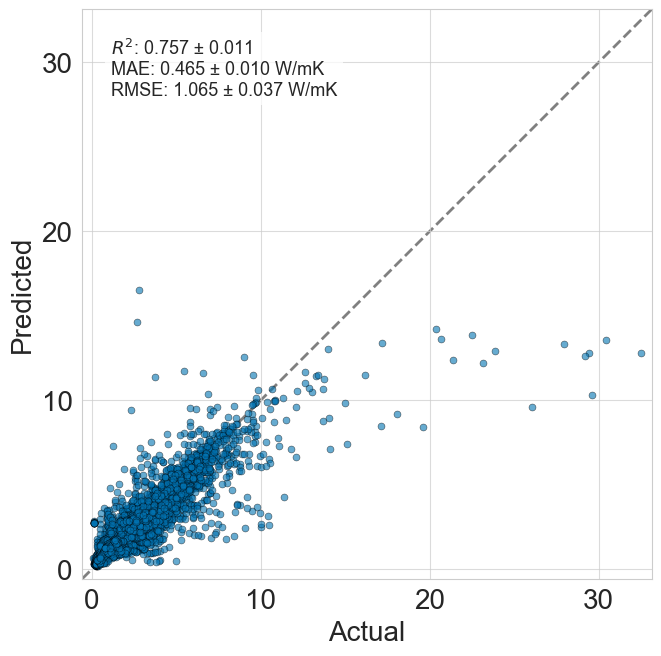

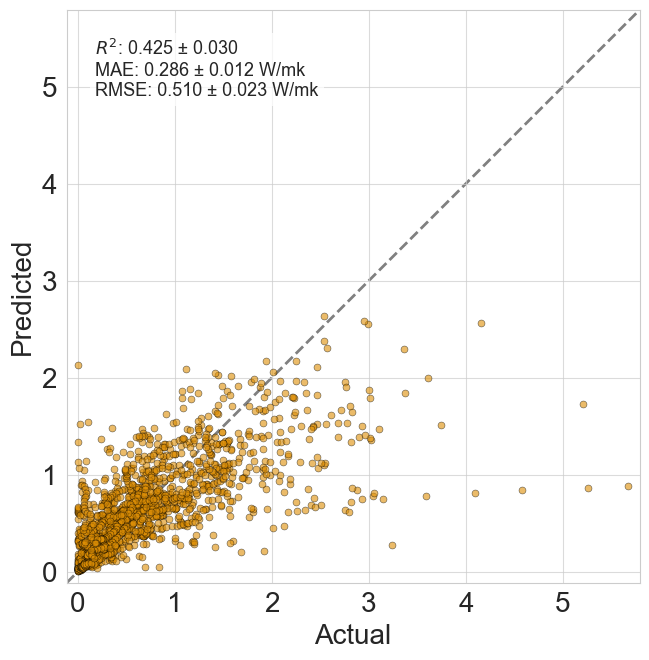

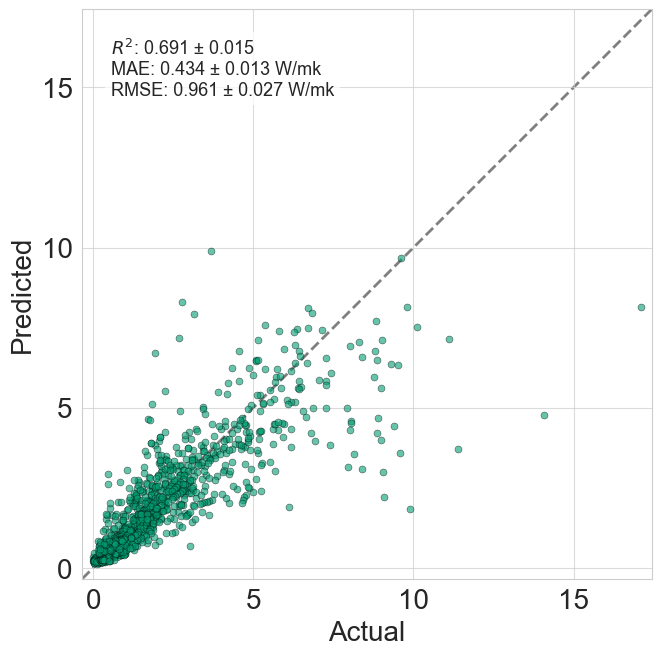

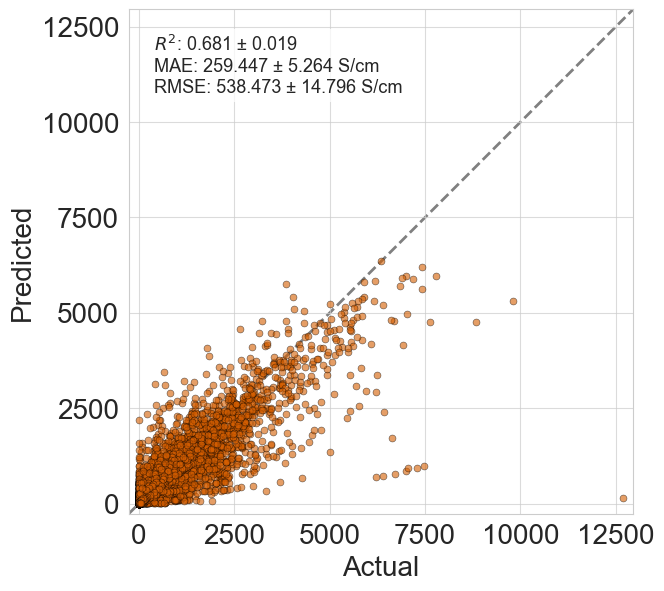

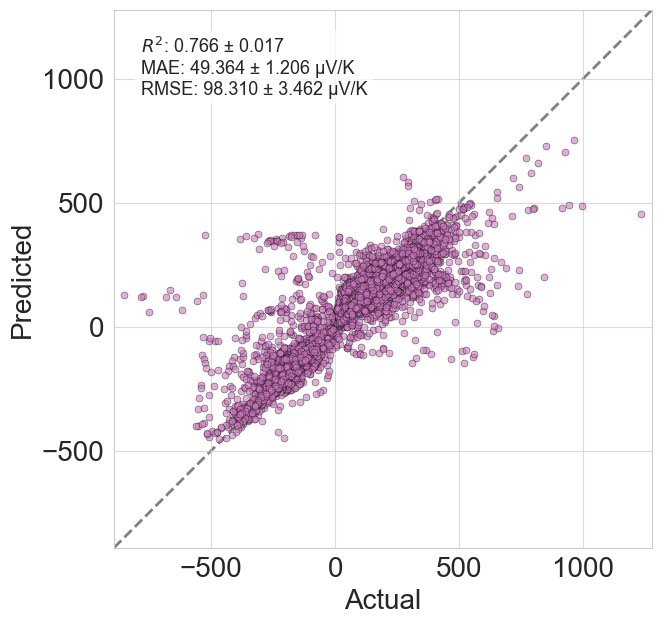

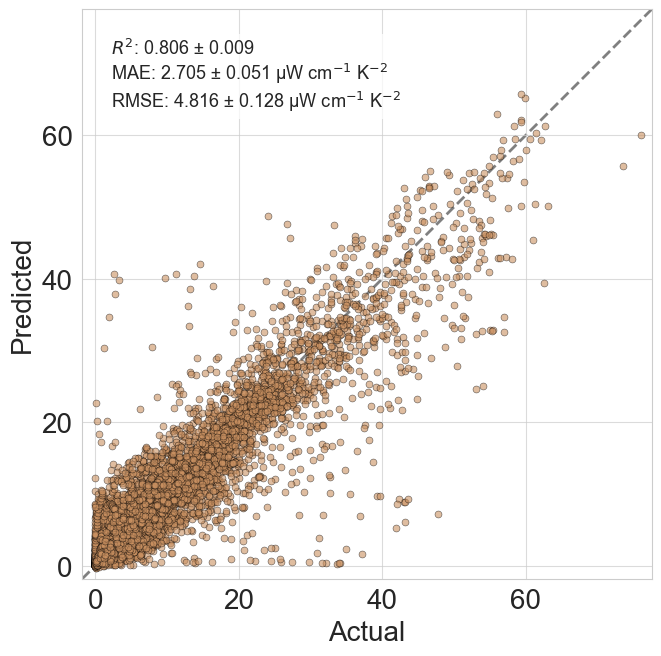

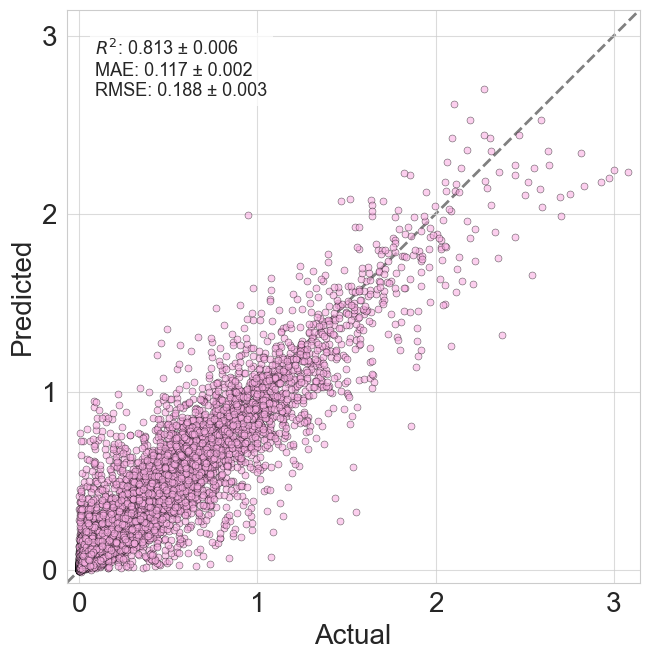

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
palette = sns.color_palette("colorblind", n_colors=len(props))
model = 'STCrabNet_concat_at_output'

actual_col = 'Actual'

predict_col = 'Predicted'

k_col = 'K_fold'

for i, (prop_key, v) in enumerate(props.items()):
    actuals = []
    predictions = []
    scores_r2 = []
    scores_mae = []
    scores_rmse = []

    for seed in seeds:
        csv_path = os.path.join(f'results/final/ST-CrabNet/SingleTask_StandardTransform_{prop_key}_RobustL2_DopedCrab_matscibert_concat_at_output_5splits_Seed{seed}.csv')
        if not os.path.exists(csv_path):
            print(f"Missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path, index_col='#')
        df = df.sort_index(ascending=True)
        actuals.append(df[actual_col].values)
        predictions.append(df[predict_col].values)

        if "K_Fold" in df.columns:
            fold_col = "K_Fold"
        elif "K_fold" in df.columns:
            fold_col = "K_fold"
        else:
            fold_col = None

        for fold in sorted(df[fold_col].unique()):
            fold_df = df[df[fold_col] == fold]
            scores_r2.append(r2_score(fold_df[actual_col], fold_df[predict_col]))
            scores_mae.append(mean_absolute_error(fold_df[actual_col], fold_df[predict_col]))
            scores_rmse.append(np.sqrt(mean_squared_error(fold_df[actual_col], fold_df[predict_col])))


    actuals = np.array(actuals)
    predictions = np.array(predictions)
    mean_actual = np.mean(actuals, axis=0)
    mean_pred = np.mean(predictions, axis=0)

    r2_mean = np.mean(scores_r2)
    r2_se = np.std(scores_r2) / np.sqrt(len(scores_r2))
    mae_mean = np.mean(scores_mae)
    mae_se = np.std(scores_mae) / np.sqrt(len(scores_mae))
    rmse_mean = np.mean(scores_rmse)
    rmse_se = np.std(scores_rmse) / np.sqrt(len(scores_rmse))

    units = v['units'] if v['units'] is not None else ""
    mae_str = f"MAE: {mae_mean:.3f} ± {mae_se:.3f}" + (f" {units}" if units else "")
    rmse_str = f"RMSE: {rmse_mean:.3f} ± {rmse_se:.3f}" + (f" {units}" if units else "")

    # --- Square parity plot ---
    fig, ax = plt.subplots(figsize=(7, 7))
    color = palette[i]
    ax.scatter(mean_actual, mean_pred, alpha=0.6, edgecolor='k', linewidth=0.4, color=color, s=25)

    # Unified limits (same for x & y) with small padding
    data_min = min(mean_actual.min(), mean_pred.min())
    data_max = max(mean_actual.max(), mean_pred.max())
    if data_max == data_min:
        data_max = data_min + 1.0
    span = data_max - data_min
    pad = 0.02 * span
    lo = data_min - pad
    hi = data_max + pad

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # Enforce exact square plotting region
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect('equal', adjustable='box')

    # Force identical tick positions (so grid cells are perfect squares)
    # Use same computed ticks for both axes.
    locator = MaxNLocator(nbins=6, steps=[1, 2, 2.5, 5, 10])
    ax.xaxis.set_major_locator(locator)
    fig.canvas.draw()  # apply locator
    xticks = ax.get_xticks()
    # Keep only ticks inside limits (sometimes Auto adds one outside)
    xticks = xticks[(xticks >= lo) & (xticks <= hi)]
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)

    ax.grid(True, which='major', linestyle='-', alpha=0.7)

    ax.plot([lo, hi], [lo, hi], linestyle='--', color='gray', lw=2, zorder=0)

    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    # ax.set_title(f"Parity Plot: {v['short_name']}")

    ax.text(
        0.05, 0.95,
        f"$R^2$: {r2_mean:.3f} ± {r2_se:.3f}\n"
        f"{mae_str}\n"
        f"{rmse_str}",
        transform=ax.transAxes,
        fontsize=13,
        va='top',
        bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
    )

    plt.tight_layout()
    # plt.savefig(f"figures/parity_{model}_{prop_key}.pdf", bbox_inches="tight")
    plt.show()

# MT Selector Vector Position Plots

In [1]:
import local_pkgs.proj_pkg.ml_plots as mplots
import os
import pandas as pd
import yaml
import local_pkgs.proj_pkg.preprocessing as preprocess
import numpy as np


with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

/Users/drago/Anaconda/anaconda3/envs/mt-crabnet_localenv/lib/python3.10/site-packages/matminer/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [4]:
## MT CrabNet
consolidated_df = pd.DataFrame()  # Used to store the results for all properties


extra_features_strategies = ['concat_at_input', 'tile_at_input', 'concat_at_output']

selector_vector_ls = ['concat_at_attn', '0', '1', '2', '3', '4']

random_seed = 42

for prop, v in config.items():
    for strategy in extra_features_strategies:
        for selector_vector in selector_vector_ls:
            r2_ls = []
            mae_ls = []
            rmse_ls = []

            file = f'results/final/MT-CrabNet/MultiTask_RobustL2_matscibert_{strategy}_onehotappend{selector_vector}_5splits_seed{random_seed}.csv'

            df_pred = pd.read_csv(file)

            # Filter the DataFrame to only include the property of interest
            df_pred = df_pred[df_pred['Property'] == v['column_name']]
            # print(df_pred.shape)


            # Generate parity plot and collect results
            scores_dict = mplots.scores_ls(
                df_pred['Actual'],
                df_pred['Predicted'],
                fold_column=df_pred['K_fold']
            )

            # Add extra columns to the results
            r2_ls.extend(scores_dict['r2_scores'])
            mae_ls.extend(scores_dict['mae_scores'])
            rmse_ls.extend(scores_dict['rmse_scores'])

            # Calculate mean and standard error for the property
            mean_r2 = np.mean(r2_ls)
            std_err_r2 = np.std(r2_ls) / np.sqrt(len(r2_ls))
            mean_mae = np.mean(mae_ls)
            std_err_mae = np.std(mae_ls) / np.sqrt(len(mae_ls))
            mean_rmse = np.mean(rmse_ls)
            std_err_rmse = np.std(rmse_ls) / np.sqrt(len(rmse_ls))

            results_dict = {
                "r2_mean" : mean_r2,
                "r2_se" : std_err_r2,
                "mae_mean" : mean_mae,
                "mae_se" : std_err_mae,
                "rmse_mean" : mean_rmse,
                "rmse_se" : std_err_rmse,
                'model_name' : f'MT CrabNet {strategy} {selector_vector}',
                'property' : prop,
                'random_seed' : random_seed
            }
            results_df = pd.DataFrame([results_dict])  # Create a single-row DataFrame
            consolidated_df = pd.concat([consolidated_df, results_df], ignore_index=True)
    

# Define the desired column order
column_order = ['model_name', 'property', 'random_seed'] + [col for col in consolidated_df.columns if col not in ['model_name', 'property', 'random_seed']]

# Reorder the columns in the DataFrame
consolidated_df = consolidated_df.reindex(columns=column_order)

# Display or save consolidated_df as needed
print(consolidated_df)

# Save the results
consolidated_df.to_csv('results/final/consolidated_selectorvectorpositions.csv', index=False)

                                    model_name property  random_seed  \
0    MT CrabNet concat_at_input concat_at_attn        k           42   
1                 MT CrabNet concat_at_input 0        k           42   
2                 MT CrabNet concat_at_input 1        k           42   
3                 MT CrabNet concat_at_input 2        k           42   
4                 MT CrabNet concat_at_input 3        k           42   
..                                         ...      ...          ...   
121              MT CrabNet concat_at_output 0       zT           42   
122              MT CrabNet concat_at_output 1       zT           42   
123              MT CrabNet concat_at_output 2       zT           42   
124              MT CrabNet concat_at_output 3       zT           42   
125              MT CrabNet concat_at_output 4       zT           42   

      r2_mean     r2_se  mae_mean    mae_se  rmse_mean   rmse_se  
0    0.791034  0.021373  0.442646  0.013691   0.996843  0.074114  
1

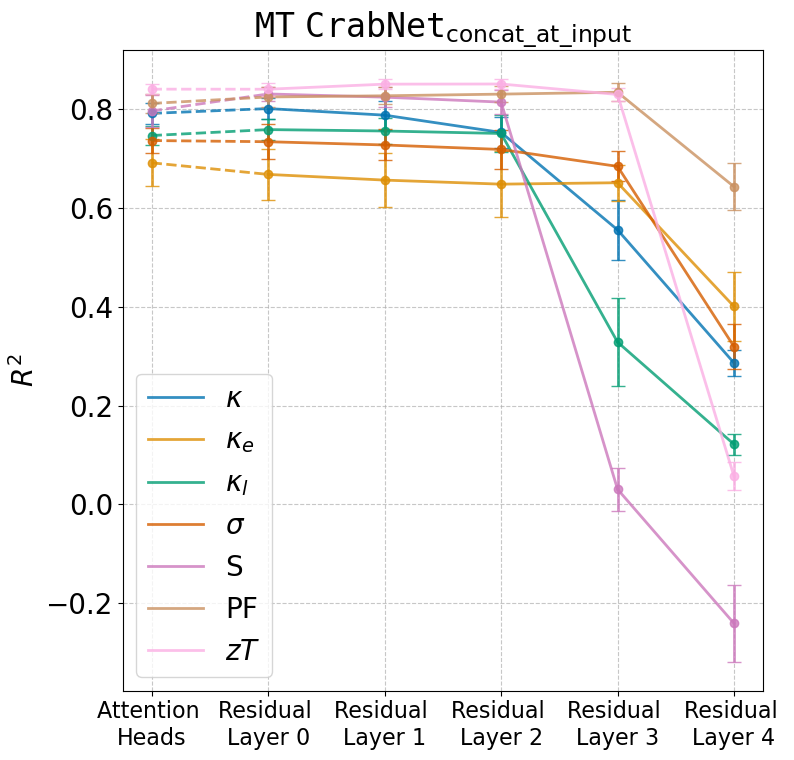

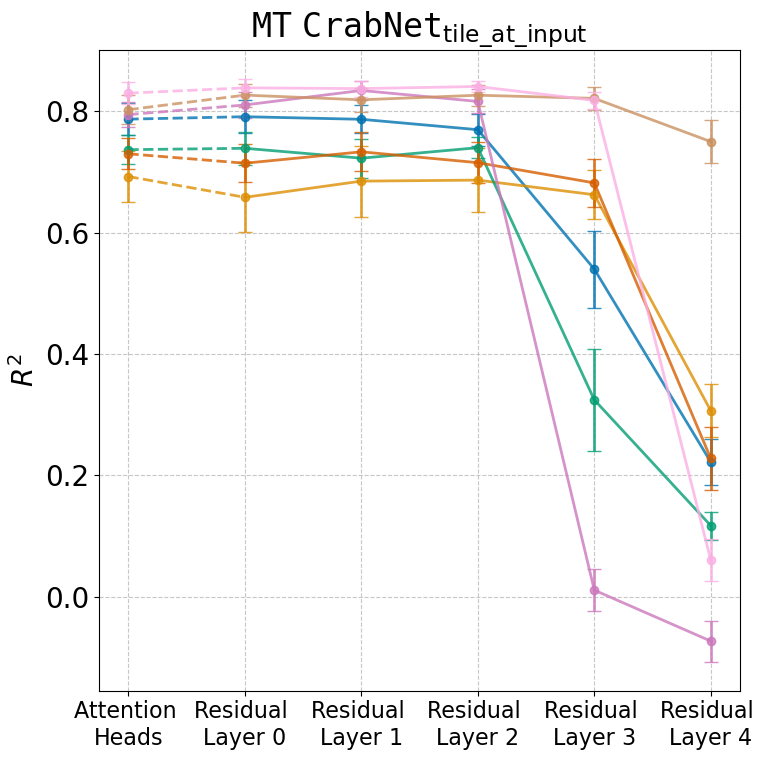

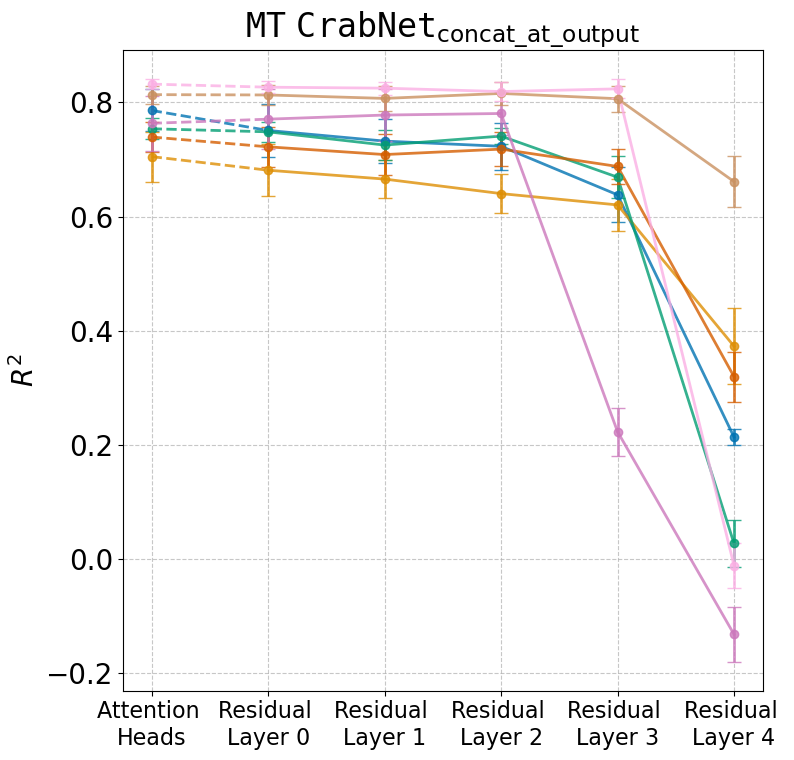

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import seaborn as sns
import local_pkgs.proj_pkg.graph_settings

# Load YAML configuration
with open('thermoelectric_properties.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load the dataset
file_path = 'results/final/consolidated_selectorvectorpositions.csv'
original_data = pd.read_csv(file_path)

temp_strats = ['concat_at_input', 'tile_at_input', 'concat_at_output']

# Define model order and corresponding simplified labels
for i, temp_strat in enumerate(temp_strats):
    
    data = original_data.copy()
    # Build model order
    model_order = [
        f'MT CrabNet {temp_strat} concat_at_attn', 
        f'MT CrabNet {temp_strat} 0', 
        f'MT CrabNet {temp_strat} 1', 
        f'MT CrabNet {temp_strat} 2', 
        f'MT CrabNet {temp_strat} 3', 
        f'MT CrabNet {temp_strat} 4',
    ]

    simplified_labels = [
        "Attention \nHeads",  # Break into two lines
        "Residual \nLayer 0", 
        "Residual \nLayer 1", 
        "Residual \nLayer 2", 
        "Residual \nLayer 3", 
        "Residual \nLayer 4"
    ]

    property_order = list(config.keys())

    # Filter data by model order
    data = data[data['model_name'].isin(model_order)]
    data['model_name'] = pd.Categorical(data['model_name'], categories=model_order, ordered=True)

    # Sort data by property and model
    data = data.sort_values(by=['property', 'model_name'])

    plt.figure(figsize=(12, 8))

    handles = []
    labels = []

    # Plot separate line plots for each property
    for j, prop in enumerate(property_order):
        # Get data for the specific property
        prop_data = data[data['property'] == prop]
        
        # Sort by the specific ordering (concat_at_attn -> 0 -> 1 -> ... -> 4)
        prop_data = prop_data.sort_values(by='model_name')
        
        # Create a new figure for each property
        
        # Plot lines between points with specific styles
        for k in range(len(prop_data) - 1):
            line_style = '--' if k == 0 else '-'  # Dotted line between "Concatenate at Attention" and "0"
            line, = plt.plot(
                [k, k + 1],
                [prop_data['r2_mean'].iloc[k], prop_data['r2_mean'].iloc[k + 1]],
                line_style,
                color=sns.color_palette('colorblind')[j], 
                alpha=0.8,
                linewidth=2
            )
        
        # Add error bars and points
        plt.errorbar(
            x=prop_data['model_name'].cat.codes,  # Convert categorical to numerical index
            y=prop_data['r2_mean'],
            yerr=prop_data['r2_se'],
            fmt='o',  # Markers only
            capsize=5,
            color=sns.color_palette('colorblind')[j],
            lw=2,
            alpha=0.8
        )

        handles.append(line)
        labels.append(config[prop]['short_name'])
        
    # Adjust plot aesthetics
    plt.xticks(
        ticks=range(len(model_order)), 
        labels=simplified_labels,  # Use simplified labels with line breaks
        ha='center',  # Center-align the text
        fontsize=16
    )

    plt.ylabel("$R^2$", fontsize=20)

    plt.title(r"$\mathtt{MT\ CrabNet}_{\mathrm{" + temp_strat.replace('_', '\_') + "}}$")

    # Add legend for the property short name
    if i == 0:
        plt.legend(handles, labels, loc='lower left', fontsize=20)

    plt.grid(axis='both', linestyle='--', alpha=0.7)

    plt.gca().set_box_aspect(1)

    # Adjust layout and show the plot
    plt.tight_layout()
    # plt.savefig(f"figures/selector_positions_{temp_strat}.pdf", bbox_inches='tight')
    plt.show()